# Second Assignment 

---

> Nikolaos Antonopoulos <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> antonopoulosn@hotmail.com

## Getting ready
* Firstly, we have to import some packages that will be needed. 

In [217]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import StandardScaler,LabelEncoder
import miceforest as mf
from statsmodels.formula.api import logit
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import sem
from sklearn import tree,metrics
from sklearn.model_selection import GridSearchCV,cross_val_score, KFold,StratifiedKFold
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score
from scipy import stats
pd.options.mode.chained_assignment = None

## Obtaining the Data


We download our data from [this link](https://www.thearda.com/Archive/Files/Downloads/BRS2014_DL2.asp)

In [218]:
data = pd.read_csv('data.csv')

Each question with each possible answers can be found in the [Codebook](https://www.thearda.com/Archive/Files/Codebooks/BRS2014_CB.asp)

* We maintain only the columns that will be needed

In [219]:
data_for_imputation = pd.DataFrame() 
needed_columns = ['Q23A','Q73C','Q73E','Q73F',
'Q73G','Q73H','Q23G','Q73B','Q17','Q31','Q88C','Q93_NONE','Q88A','AGE','Q77','Q90',
'Q88B','Q73A','RELTRAD','Q88D','Q73D','Q88E','Q88F','Q89','Q4','Q95','I_MARITAL',
'Q93','Q80','Q51A','Q23C','STATE']
data=data[needed_columns]

In [220]:
data

,Q23A,Q73C,Q73E,Q73F,Q73G,Q73H,Q23G,Q73B,Q17,Q31,...,Q88F,Q89,Q4,Q95,I_MARITAL,Q93,Q80,Q51A,Q23C,STATE
0,4.0,1.0,2.0,1.0,2.0,1.0,4.0,1.0,1.0,1.0,...,NaN,1.0,8.0,2.0,3.0,NaN,4.0,5.0,4.0,TX
1,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1.0,4.0,...,NaN,NaN,1.0,1.0,3.0,2.0,1.0,5.0,4.0,TX
2,3.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,6.0,...,2.0,1.0,7.0,3.0,1.0,NaN,3.0,1.0,2.0,ND
3,4.0,1.0,1.0,2.0,1.0,2.0,4.0,1.0,2.0,2.0,...,2.0,NaN,6.0,2.0,3.0,NaN,2.0,5.0,4.0,TX
4,4.0,1.0,1.0,1.0,1.0,2.0,4.0,1.0,1.0,2.0,...,2.0,NaN,8.0,5.0,2.0,2.0,1.0,2.0,4.0,IA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,4.0,1.0,1.0,NaN,NaN,2.0,4.0,NaN,1.0,3.0,...,NaN,2.0,1.0,5.0,2.0,NaN,3.0,2.0,2.0,CA
1568,3.0,2.0,2.0,2.0,1.0,2.0,3.0,1.0,2.0,4.0,...,NaN,5.0,0.0,4.0,2.0,1.0,1.0,2.0,3.0,CA
1569,4.0,2.0,1.0,2.0,1.0,2.0,3.0,1.0,2.0,4.0,...,2.0,2.0,7.0,2.0,1.0,NaN,3.0,1.0,4.0,CA
1570,3.0,2.0,1.0,2.0,1.0,2.0,3.0,1.0,2.0,6.0,...,NaN,3.0,3.0,5.0,2.0,0.0,1.0,3.0,3.0,CT


# 1ST QUESTION


In order to measure the belief in supernatural evil, we have to take a look in 3 questions: 

* Whether the respondent believes in the devil.

* Whether the respondent believes in hell.

* Whether the respondent believes in demons.

These, correspond to the following: 
* Q23A
* Q23C
* Q23G

In [221]:
supernatural_evil_questions = data[["Q23G","Q23C","Q23A"]] 

What we want to do, is combine them into a single metric.  
One would say to take the average of them, but is this correct?

Before doing that, we have to make sure that we are allowed to.  
Thankfully, there are 2 tools that help us check just that.
* PCA 
* Factor Analysis 

## PCA

"PCA is a statistical procedure that allows you to summarize the information content in large data tables by means of a smaller set of “summary indices” that can be more easily visualized and analyzed". [source](https://www.sartorius.com/en)


*Note: Later on in this project, we will use a technique called multiple imputation to fill the values of the missing data.  For now however we will drop the NaN values to perform our PCA*

We want to check 2 conditions before doing this: 
* First, that each metric doesn't have many null values 
* Second, that each metric has about the same amount of null values as the others

In [222]:
supernatural_evil_questions.isnull().mean()

Q23G    0.050891
Q23C    0.046438
Q23A    0.043257
dtype: float64

Both conditions are fullfield since all the metrics are ~5%. 

In [223]:
supernatural_evil_questions_na_dropped = supernatural_evil_questions.copy()
supernatural_evil_questions_na_dropped.dropna(inplace=True) 

*Note: PCA was also performed with multiple imputation and the results were the same with the ones shown below*

Since all the columns are in the same scale, there is no need to transform our data.  
Let's perform PCA with 2 components.

In [224]:
pca = PCA(n_components=2)
pca.fit(supernatural_evil_questions_na_dropped)
print(pca.explained_variance_ratio_)

[0.90171495 0.0634095 ]


It is clear that the first component explains a huge component of the variance (PVE).  
However, the second component explains insignificant proportion of the variance.  
We can understand this better by presenting what is happening graphically!  

Text(0, 0.5, 'PVE')

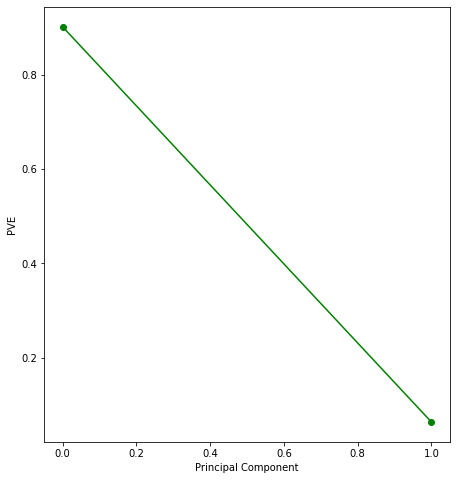

In [225]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(pca.explained_variance_ratio_, marker='o',color='g')
plt.xlabel('Principal Component')
plt.ylabel('PVE')

The first point, shows us that the first component explains about 90% of the variance but when we move to the second it falls under 10%

*Note: If we tried the maximum amount of components, which is 3, the third component would explain even smaller proportion of the variance.*

So, let's use only 1 component for our PCA. 

In [226]:
pca = PCA(n_components=1)
pca.fit(supernatural_evil_questions_na_dropped)
print(pca.components_) 

[[-0.56804263 -0.57818501 -0.58568735]]


What do we note?  
We note that all the values are almost equal.  
This tells us that we can indeed get the average of the 3 metrics to find a single metric.

We can cross validate the excact same thing using another technique, called Factor Analysis.  

## Factor Analysis

Factor analysis is very similar to PCA. It is often used to reduce a large number of variables into fewer numbers of factors.

Before performing factor analysis, we have to check wether there are factors in this dataset. 
There are 2 paths to resolve this: 
* Bartlett's Test
* Kaiser-Meyer-Olkin Test

### Bartlett's Test

Bartlett's Test will check wether our 3 variables intercorrelate.  We want to see if the result is be statistically significant.

In [227]:
chi_square_value,p_value=calculate_bartlett_sphericity(supernatural_evil_questions_na_dropped)
p_value

0.0

p-value is 0, indicating statistic significance 

### KMO Test

KMO Test determines again if the data is good for factor analysis.  
KMO shows the proportion of variance among the variables.  
It gives prices between 0 and 1. What we want, is a value greater than 0.6

In [228]:
kmo_all,kmo_model=calculate_kmo(supernatural_evil_questions_na_dropped)
kmo_model

0.7549696887557487

The KMO for our dataset is 0.75 which is good.  
So, after having done these 2 tests, we can proceed with the factor analysis.

Let's perform Factor Analysis with all 3 factors 

In [229]:
fa = FactorAnalyzer(n_factors=3)
fa.fit(supernatural_evil_questions_na_dropped)
ev, v = fa.get_eigenvalues()
ev 

array([2.70509088, 0.19033651, 0.10457261])

We notice that only 1 eigenvalue, the first one, is greater one. This means that we should choose only one factor.

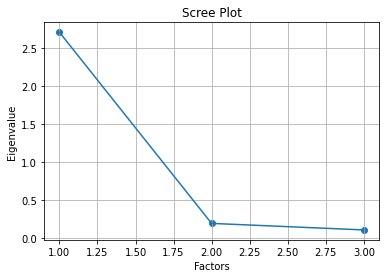

In [230]:
plt.scatter(range(1,supernatural_evil_questions_na_dropped.shape[1]+1),ev)
plt.plot(range(1,supernatural_evil_questions_na_dropped.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

From the Scree plot we can see that the 1 variable can explain most of the information, but when we add more factors the explanation decreases significantly. 

In [231]:
fa = FactorAnalyzer()
fa.set_params(n_factors = 1)
fa.fit(supernatural_evil_questions_na_dropped)
loadings = fa.loadings_
-loadings

C:\Users\Νίκος\AppData\Local\Programs\Python\Python39\lib\site-packages\factor_analyzer\factor_analyzer.py:656: UserWarning: No rotation will be performed when the number of factors equals 1.
  warnings.warn('No rotation will be performed when '


array([[0.88706698],
       [0.91625195],
       [0.9672857 ]])

Having done both PCA and Factor Analysis, we are confident that we can indeed combine the 3 metrics:
* Whether the respondent believes in the devil.

* Whether the respondent believes in hell.

* Whether the respondent believes in demons.

to a single metric called supernatural_Evil

# 2ND QUESTION

For this question, we have to derive descriptive statistics for some variables and encode them with dummy variables where needed. 

The variables are: 
* Dependent Variables

  * Ban on Semi-Auto Guns
  * Ban on High-Capacity Ammo Clips 
  * Banning Civilian Handguns
  * Support for Concealed Carry Laws 
  * More Armed Security at Schools 
  * More Teachers/Faculty having Guns 
  * More Gun Safety Programs 
  * Expanded Mental Health Screening
  
* Independept Variables
 
   * Religious Variables
     * Attendance
     * Bible (Human Error, History and Fables) 
     * Biblical Inerrancy
     * Biblical Literalism
     
  * Religious Affiliation
    * Conservative Protestant 
    * Mainline Protestant 
    * Black Protestant 
    * Catholic
    * Other
    * No Affiliation
  * Political Ideology
  * Age
  * Sex
    * Female
    * Male
  * Race
    * White
    * Hispanic
    * African American/Black 
    * Other
  * Education
    * Less Than High School 
    * High School or Equivalent 
    * Some College
    * College Degree 
    * Post-graduate Degree 
  * Household Income
  * Marital Status
    * Not Partnered/Single 
    * Married/Cohabitating
  * Children
    * No kids under 18 in home 
    * Kids under 18 in home
  * Area Demographics
    * Small Town/Rural
    * Urban Area
  * Region
    * South
    * Other Region

We will begin with the dependent variables.  
In order to avoid repetitive code, we will create a funuction that will create dummy variables for the dependent variables.

The method create_dummy_for_dependent takes as input:
* The unique name of the question e.g. Q89 
* The desired column name that will be returned

*Remember* that we still have null values.  The get_dummies method will ignore the nan values which is something that we do not want to happen since we agreed on dealing with them later.  So, we will create a new column containing the null values using the command 'dummy_na=True'. After that, we wll combine this column with our dummy column.  
We can understand this better with an example.
By using the get_dummies method we would get: 


| ban_on_semi_auto_guns      | NaN |
| :-----------: | :-----------: |
|1|0|
|0|1|  
|0|1|
|1|0|

With the last part of this method we combine this to: 

| ban_on_semi_auto_guns |
| :-----------: | 
|1|
|NaN| 
|NaN|
|1|      


Which is probably what the paper's writers did considering the fact that the descriptive statistics are the same.  

In [232]:
def create_dummy_for_dependent(question_name,column_name):
    ban_on_semi_auto_guns=data[question_name]
    dummy_name = pd.get_dummies(ban_on_semi_auto_guns,drop_first=True, dummy_na=True)
    dummy_name.rename(columns = {2:column_name}, inplace = True)
    dummy_name.rename(columns={ dummy_name.columns[0]: column_name,dummy_name.columns[-1]: "nan" }, inplace = True)
    dummy_name.loc[dummy_name.nan == 1,:] = np.nan
    del dummy_name["nan"]
    return 1-dummy_name

### Dependent Variables

#### Ban on semi auto 

In [233]:
ban_on_semi_auto_guns_dummy = create_dummy_for_dependent('Q73A','ban_on_semi_auto_guns')

The dummy variable looks like this:
* 0 means that the respondent is opposed in banning semi auto weapons 
* 1 means that he is in favor of banning semi auto weapons 

In [234]:
ban_on_semi_auto_guns_dummy

,ban_on_semi_auto_guns
0,0.0
1,NaN
2,1.0
3,1.0
4,1.0
...,...
1567,NaN
1568,1.0
1569,1.0
1570,1.0


While the mean is:

In [235]:
mean = ban_on_semi_auto_guns_dummy.mean()
"{:.1f}".format(float(mean)*100)

'62.9'

Similarly we create the other dependent variables

#### Ban on high-Capacity ammo clips 

In [236]:
ban_on_high_capacity_ammo_clips_dummy = create_dummy_for_dependent('Q73E','ban_on_high_capacity_ammo_clips')

In [237]:
mean = ban_on_high_capacity_ammo_clips_dummy.mean()
"{:.1f}".format(float(mean)*100)

'67.1'

#### Banning civilian handguns


In [238]:
banning_civilian_handguns_dummy = create_dummy_for_dependent('Q73G','ban_on_civilian_handguns')

In [239]:
mean = banning_civilian_handguns_dummy.mean()
"{:.1f}".format(float(mean)*100)

'29.0'

#### Support for concealed carry laws

In [240]:
support_for_Concealed_Carry_Laws_dummy = create_dummy_for_dependent('Q73H','support_for_Concealed_Carry_Laws')

In [241]:
mean = support_for_Concealed_Carry_Laws_dummy.mean()
"{:.1f}".format(float(mean)*100)

'55.8'

#### More armed security at schools 

In [242]:
more_Armed_Security_at_Schools_dummy = create_dummy_for_dependent('Q73C','more_Armed_Security_at_Schools')

In [243]:
mean = more_Armed_Security_at_Schools_dummy.mean()
"{:.1f}".format(float(mean)*100)

'62.2'

#### More teachers having guns

In [244]:
more_Teachers_Faculty_having_Guns_dummy = create_dummy_for_dependent('Q73F','more_Teachers_Faculty_having_Guns')

In [245]:
mean = more_Teachers_Faculty_having_Guns_dummy.mean()
"{:.1f}".format(float(mean)*100)

'29.5'

#### Safety Programs

In [246]:
more_Gun_Safety_Programs_dummy = create_dummy_for_dependent('Q73B','more_Gun_Safety_Programs')

In [247]:
mean = more_Gun_Safety_Programs_dummy.mean()
"{:.1f}".format(float(mean)*100)

'92.7'

#### Mental Health

In [248]:
expanded_Mental_Health_Screening_dummy = create_dummy_for_dependent('Q73D','expanded_Mental_Health_Screening')

In [249]:
mean = expanded_Mental_Health_Screening_dummy.mean()
"{:.1f}".format(float(mean)*100)

'90.8'

### Focal Variable

#### Supernatural Evil

In [250]:
supernatural_evil_questions["supernatural_evil"] = supernatural_evil_questions.mean(axis=1)
supernatural_Evil = supernatural_evil_questions['supernatural_evil']

<u> Mean</u>:

In [251]:
mean = supernatural_Evil.mean()
"{:.1f}".format(float(mean)*100)

'309.0'

<u>Standard Deviation</u>:

In [252]:
"{:.2f}".format(float(np.std(supernatural_Evil)))

'1.05'

### Religious Variables 

#### Attendance

Attendance, corresponds to question q4.

In [253]:
data.rename(columns = {'Q4':'attendance'}, inplace = True)
attendance = data['attendance']

<u> Mean</u>:

In [254]:
mean = attendance.mean()
"{:.2f}".format(float(mean))

'3.68'

<u>Standard Deviation</u>:

In [255]:
"{:.2f}".format(float(np.std(attendance)))

'2.93'

### Religious Variables

#### Bible(Human Error, History and Fables)

The dependent variables only had 2 possible values, 0 and 1.  
However, in this case our variables have more than 2 available values. 
Specifically, question Q17 which concerns personal beliefs about the bible, can take values from [1,4] U {8}   
So, we will create a new function which will work the similarly to 'create_dummy_for_dependent' method.  
The name of this function will be create_dummy_with_many_fields and will take as input:
* The unique name of the question e.g. Q17
* The list of names that we want each choice to get.


| No.Question | Meaning     | Name that we give |
| :-----------: | :-----------: | :-----------: |
|1|The Bible means exactly what it says. It should be taken literally, word-for-word, on all subjects.|literalism|
|2|The Bible is perfectly true, but it should not be taken literally, word-for-word. We must interpret its meaning.|inerrancy|  
|3|The Bible contains some human error.|human_error|
|4|The Bible is an ancient book of history and legends.|legends|
|8|I don't know.|idk|

In [256]:
def create_dummy_with_many_fields(question_name,list_of_names):
    dummies = pd.get_dummies(data[question_name], dummy_na=True)
    for x in range (len( dummies.columns)-1):
        dummies.rename(columns = {dummies.columns[x]:list_of_names[x]}, inplace = True)
    dummies.rename(columns={dummies.columns[-1]: "nan" }, inplace = True)
    dummies.loc[dummies.nan == 1, :] = np.nan
    del dummies['nan']
    return dummies


So, having created this method, we can simply call it for each variable that we want to create.  
Ones more, we save lot of time and memory.  

In [257]:
list_of_names=['literalism','inerrancy','human_error','legends','idk']
bible_dummy = create_dummy_with_many_fields('Q17',list_of_names)

#### Bible

The first variable, 'Bible' that we want to create consists of the sum of 3 repsponses.  
To get more specific, we will count the amount of the respondents who chose the answers: 3,4,8  
These, correspond to human_error, legends and idk.

In [258]:
bible_history = bible_dummy['human_error'] + bible_dummy['legends'] + bible_dummy['idk']
bible_history = bible_history.to_frame()
bible_history.rename(columns = {0:'bible_history'}, inplace = True)
bible_humanerror_history_fables = bible_history['bible_history']

<u> Mean</u>:

In [259]:
mean = bible_humanerror_history_fables.mean()
"{:.1f}".format(float(mean)*100)

'43.3'

#### Biblical Inerrancy

In [260]:
biblical_inerrancy = bible_dummy['inerrancy']

<u> Mean</u>:

In [261]:
mean = biblical_inerrancy.mean()
"{:.1f}".format(float(mean)*100)

'33.8'

#### Biblical Literalism

In [262]:
biblical_literalism = bible_dummy['literalism']

<u> Mean</u>:

In [263]:
mean = biblical_literalism.mean()
"{:.1f}".format(float(mean)*100)

'22.9'

### Religious Affiliation

'Religious Tradition' question has multiple values just like Bible that we did above.  
So we will use the same method that we created.  
Again, we pass as an argument the names that we want to match each question.  
Let's visualise them


| No.Question | Meaning     | Name that we give |
| :-----------: | :-----------: | :-----------: |
|1|Evangelical Protestant|conservative_protestant|
|2|Mainline Protestant| mainline_protestant|
|3|Black Protestant| black_protestant|
|4|Catholic|catholic|
|5|Jewish|jewish|
|6|Other|other_religion|
|7|No Affiliation|no_affiliation|

In [264]:
list_of_names=['conservative_protestant','mainline_protestant','black_protestant','catholic','jewish','other_religion','no_affiliation']
religious_affiliation = create_dummy_with_many_fields('RELTRAD',list_of_names)
religious_affiliation

,conservative_protestant,mainline_protestant,black_protestant,catholic,jewish,other_religion,no_affiliation
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1567,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1568,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1569,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1570,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Conservative protestant


In [265]:
conservative_protestant=religious_affiliation['conservative_protestant']

<u> Mean</u>:

In [266]:
mean = conservative_protestant.mean()
"{:.1f}".format(float(mean)*100)

'28.4'

#### Mainline protestant

In [267]:
mainline_protestant = religious_affiliation['mainline_protestant']

<u> Mean</u>:

In [268]:
mean = mainline_protestant.mean()
"{:.1f}".format(float(mean)*100)

'16.9'

#### Black protestant

In [269]:
black_protestant = religious_affiliation['black_protestant']

<u> Mean</u>:

In [270]:
mean = black_protestant.mean()
"{:.1f}".format(float(mean)*100)

'7.2'

#### Catholic

In [271]:
catholic = religious_affiliation['catholic']

<u> Mean</u>:

In [272]:
mean = catholic.mean()
"{:.1f}".format(float(mean)*100)

'24.9'

#### Other Religions

In [273]:
other_religion = religious_affiliation['jewish']+religious_affiliation['other_religion']

<u> Mean</u>:

In [274]:
mean = other_religion.mean()
"{:.1f}".format(float(mean)*100)

'8.2'

#### No affiliation

In [275]:
no_affiliation = religious_affiliation['no_affiliation']

<u> Mean</u>:

In [276]:
mean = no_affiliation.mean()
"{:.1f}".format(float(mean)*100)

'14.4'

### Mediator

#### Political Ideology

In [277]:
data.rename(columns = {'Q31':'Political_Ideology'}, inplace = True)
political = data['Political_Ideology']

<u> Mean</u>:

In [278]:
mean = political.mean()
"{:.2f}".format(float(mean))

'3.80'

<u>Standard Deviation</u>:

In [279]:
"{:.2f}".format(float(np.std(political)))

'1.55'

### Controls 

The first variable here is age.  
Let's get its mean value 

In [280]:
data['AGE'].mean()

49.162213740458014

At first sight, it seems alright but let's count the unique values.

In [281]:
data['AGE'].value_counts().head(3)

0     104
67     40
59     40
Name: AGE, dtype: int64

Hmm, this is kind of odd.  
Unborn babies are not known for their ability to fill in questionnaires.

Let's see how many null values there are.

In [282]:
data['AGE'].isna().sum()

0

Since we haven't done the imputaton yet, having 0 missing values does not seem correct. 
Apparently, in our dataset, when the respondent didn't provide his age, instead of null, the value was filled with 0. This, obviously affects the mean. So let's fix it.

In [283]:
data['AGE'] = data['AGE'].replace(0, np.nan)

In [284]:
age = data['AGE']

<u> Mean</u>:

In [285]:
mean = age.mean()
"{:.2f}".format(float(mean))

'52.65'

<u>Standard Deviation</u>:

In [286]:
"{:.2f}".format(float(np.std(age)))

'17.01'

#### Female

In [287]:
gender_male = create_dummy_for_dependent('Q77','male')

<u> Mean</u>:

In [288]:
mean = gender_male.mean()
"{:.2f}".format(float(mean))

'0.42'

#### Male

In [289]:
gender_female = 1-gender_male
gender_female.rename(columns = {gender_male.columns[0]:'female'}, inplace = True) 

<u> Mean</u>:

In [290]:
mean = gender_female.mean()
"{:.2f}".format(float(mean))

'0.58'

### Race

Encoding race is a bit tricky.  We have to combine questions Q88 and Q89

Let's take a look at Q88. 
Q88 consists of 6 questions. If the respondent is:
* White
* Black or African American
* American Indian or Alaska Native 
* Asian 
* Native Hawaiian or other Pacific Islander
* Other race  

The user places 1 if he is from a specific race and 2 otherwise.

In [291]:
data[['Q88A','Q88B','Q88C','Q88D','Q88E','Q88F']]

,Q88A,Q88B,Q88C,Q88D,Q88E,Q88F
0,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,1.0,2.0,2.0,2.0,NaN
2,1.0,2.0,2.0,2.0,2.0,2.0
3,1.0,2.0,2.0,2.0,2.0,2.0
4,1.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...
1567,NaN,NaN,NaN,NaN,NaN,NaN
1568,NaN,NaN,NaN,NaN,NaN,NaN
1569,2.0,2.0,2.0,2.0,2.0,2.0
1570,NaN,NaN,NaN,NaN,NaN,NaN


Let's take a look at Q89.  
Unlike Q88, Q89 takes values from [1,5] U {8}
* 1 means that the respondent is not hispanic or latino
* 2,3,4,5,8 means that he is hispanic or latino

In [292]:
data['Q89'].value_counts()

1.0    714
2.0     98
5.0     43
3.0     19
8.0     17
4.0     15
Name: Q89, dtype: int64

Both questions refer to race so it would be easier for us to work with them if we made them similar.  
We said that 1 indicates NOT hispanic or latino race.
So we will place 0 in every other answer than 1 which will indicate hispanic or latino race. 

In [293]:
data_hispanic = data['Q89']
data_hispanic[data['Q89'] > 1] = 0
data_hispanic = data_hispanic.to_frame()
data_hispanic.value_counts()

Q89
1.0    714
0.0    192
dtype: int64

We are getting closer!  
Remember though that Q88 only takes 1 and 2 as values.
* 1 -> My Race
* 2-> Not my Race

So, we will simply add 1 to our column  
And we are done!

In [294]:
data_hispanic['Q89'] = data_hispanic['Q89'] + 1
data['Q89'] = data_hispanic['Q89']
data['Q89'].value_counts()

2.0    714
1.0    192
Name: Q89, dtype: int64

Now, we are in the position to combine the 2 questions since they are in the same scale.  
We also rename them to understand them easier.

In [295]:
race_dataframe=data[['Q88A','Q88B','Q88C','Q88D','Q88E','Q88F','Q89']]#
race_dataframe = race_dataframe.rename(columns={'Q88A': 'White', 
'Q88B': 'Black_or_African_American','Q88C': 'American_Indian_or_Alaska_Native',
'Q88D': 'Asian','Q88E': 'Native_Hawaiian_or_other_Pacific_Islander','Q88F': 'other_race_percentage','Q89': 'Hispanic_or_Latino'})#'

In [296]:
race_dataframe

,White,Black_or_African_American,American_Indian_or_Alaska_Native,Asian,Native_Hawaiian_or_other_Pacific_Islander,other_race_percentage,Hispanic_or_Latino
0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,2.0,1.0,2.0,2.0,2.0,NaN,NaN
2,1.0,2.0,2.0,2.0,2.0,2.0,2.0
3,1.0,2.0,2.0,2.0,2.0,2.0,NaN
4,1.0,2.0,2.0,2.0,2.0,2.0,NaN
...,...,...,...,...,...,...,...
1567,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1568,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1569,2.0,2.0,2.0,2.0,2.0,2.0,1.0
1570,NaN,NaN,NaN,NaN,NaN,NaN,1.0


As most of the times when dealing with data, our data are problematic.  
Some respondents have placed 1 on their race but haven't answered the questions of other races.  
This results in a line which is considered invalid.  


| White | Black_or_African_American     | American_Indian_or_Alaska_Native|Asian|Native_Hawaiian_or_other_Pacific_Islander|other_race_percentage|Hispanic_or_Latino|
| :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: |:-----------: |
|2|NaN|2|NaN|NaN|1|NaN|


To solve this, we create a method called 'race_method'  
'race_method' iterates 'race_dataframe' and for each line, if the line has at least one column with value '1',  
indicating that the repspondent has declared his race, we place 2 in the columns that are not equal to 1.  

The above example would transform into:

| White | Black_or_African_American     | American_Indian_or_Alaska_Native|Asian|Native_Hawaiian_or_other_Pacific_Islander|other_race_percentage	|Hispanic_or_Latino|
| :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: |:-----------: |
|2|2|2|2|2|1|2|

So, now we not that the respondent belongs to the category 'other_race' and the line is now valid!

In [297]:
def race_method(race_to_be_removed,row_to_be_changed):
    list = ['White','Black_or_African_American','American_Indian_or_Alaska_Native','Asian','Native_Hawaiian_or_other_Pacific_Islander','other_race_percentage','Hispanic_or_Latino']
    list.remove(race_to_be_removed)
    for i in list:
        if(row_to_be_changed[i]!=1):
            row_to_be_changed[i] = 2
    return row_to_be_changed
    
    

In [298]:
for index, row in race_dataframe.iterrows():
    if row['White'] == 1:
        row = race_method(race_to_be_removed='White',row_to_be_changed=row)
    elif row['Black_or_African_American'] == 1:
        row = race_method(race_to_be_removed='Black_or_African_American',row_to_be_changed=row)
    elif row['Hispanic_or_Latino'] == 1:
        row = race_method(race_to_be_removed='Hispanic_or_Latino',row_to_be_changed=row)
    elif row['American_Indian_or_Alaska_Native'] == 1:
        row = race_method(race_to_be_removed='American_Indian_or_Alaska_Native',row_to_be_changed=row)
    elif row['Asian'] == 1:
        row = race_method(race_to_be_removed='Asian',row_to_be_changed=row)
    elif row['Native_Hawaiian_or_other_Pacific_Islander'] == 1:
        row = race_method(race_to_be_removed='Native_Hawaiian_or_other_Pacific_Islander',row_to_be_changed=row)
    elif row['other_race_percentage'] == 1:
            row = race_method(race_to_be_removed='other_race_percentage',row_to_be_changed=row)

We create a method for the creation of the dummies, very similar to the ones we built above

In [299]:
def create_dummy_for_race(column,column_name):
    race_dummy = pd.get_dummies(column,dummy_na=True)
    race_dummy.loc[race_dummy.columns[-1] == 1, :] = np.nan
    race_dummy.rename(columns = {1:column_name}, inplace = True)
    race_dummy.drop(index=race_dummy.index[-1], axis=0, inplace=True)
    return race_dummy

#### White

In [300]:
white = create_dummy_for_race(race_dataframe['White'],column_name='white')
white = white['white']

<u> Mean</u>:

In [301]:
mean = white.mean()
"{:.1f}".format(float(mean)*100)

'74.7'

#### Hispanic

In [302]:
hispanic = create_dummy_for_race(race_dataframe['Hispanic_or_Latino'],column_name='Hispanic_or_Latino')
hispanic = hispanic['Hispanic_or_Latino']

<u> Mean</u>:

In [303]:
mean = hispanic.mean()
"{:.1f}".format(float(mean)*100)

'12.2'

#### African American/Black

In [304]:
african_american = create_dummy_for_race(race_dataframe['Black_or_African_American'],column_name='Black_or_African_American')
african_american = african_american['Black_or_African_American']

<u> Mean</u>:

In [305]:
mean = african_american.mean()
"{:.1f}".format(float(mean)*100)

'11.4'

#### Other

In [306]:
other_race = 1 - white - hispanic - african_american  

<u> Mean</u>:

In [307]:
other_race = other_race.to_frame()
other_race = other_race.rename(columns={0: 'other_race'})
other_race = other_race['other_race']

In [308]:
mean = other_race.mean()
"{:.1f}".format(float(mean)*100)

'1.7'

#### Education

Education is represented by question Q90.  
Let's see the possible values.  

In [309]:
data['Q90'].value_counts()

6.0    393
4.0    362
7.0    335
3.0    201
5.0    121
2.0     67
1.0     22
Name: Q90, dtype: int64

Since Education has many values, we will use the 'create_dummy_with_many_fields' method that we created before.  
Let's once again visualise the questions and match them with names.  


| No.Question | Meaning     | Name that we give |
| :-----------: | :-----------: | :-----------: |
|1|8th grade or less|8th|
|2|9th-12th grade (no high school diploma)|9th_12th|  
|3|High school graduate|high_school|
|4|Some college|some_college|
|5| Trade/Technical/Vocational training|trade_tech|
|6|College graduate|college|
|7|Postgraduate work/Degree|post_grad|

In [310]:
list_of_names=['8th','9th_12th','high_school','some_college','trade_tech','college','post_grad']

We assign the dummies to a datafrme that we name 'educ'.  This df has 7 columns, one for each question from above.  

In [311]:
educ = create_dummy_with_many_fields('Q90',list_of_names)
educ

,8th,9th_12th,high_school,some_college,trade_tech,college,post_grad
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1567,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1568,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1569,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1570,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Less than High School 

Less than high school would be considered as the union of:
* 8th grade or less (which corresponds to answer number '1' that we named '8th')
* 9th-12th grade (no high school diploma)(which corresponds to answer number '2' that we named '9th_12th')  

So we add these.  

In [312]:
less_than_high_school =  educ['8th']+educ['9th_12th']
less_than_high_school.mean()

0.059293804130579615

<u>Mean</u>:

In [313]:
mean = less_than_high_school.mean()
"{:.2f}".format(float(mean)*100)

'5.93'

#### High School or Equivalent 

In [314]:
high_school_or_equivalent = educ['high_school']

<u>Mean</u>:

In [315]:
mean = high_school_or_equivalent.mean()
"{:.1f}".format(float(mean)*100)

'13.4'

#### Some college

In [316]:
some_college = educ['trade_tech']+educ['some_college']
some_college.mean()

0.3217854763491006

<u>Mean</u>:

In [317]:
mean = some_college.mean()
"{:.1f}".format(float(mean)*100)

'32.2'

#### College degree

In [318]:
college_degree = educ['college']
college_degree.mean()

0.2618254497001999

<u>Mean</u>:

In [319]:
mean = college_degree.mean()
"{:.1f}".format(float(mean)*100)

'26.2'

#### Post-graduate degree

In [320]:
post_grad = educ['post_grad']
post_grad.mean()

0.22318454363757495

<u>Mean</u>:

In [321]:
mean = post_grad.mean()
"{:.1f}".format(float(mean)*100)

'22.3'

#### Household Income

In [322]:
data.rename(columns = {'Q95':'household_income'}, inplace = True)
household_income = data['household_income']

<u>Mean</u>:

In [323]:
mean = household_income.mean()
"{:.2f}".format(float(mean))

'4.15'

<u>Standard Deviation</u>:

In [324]:
"{:.2f}".format(float(np.std(household_income)))

'1.71'

#### Married/Cohabiated

Q51 corresponds to questions regarding marriage.  
Let's see the possbile values.

In [325]:
data['Q51A']

0       5.0
1       5.0
2       1.0
3       5.0
4       2.0
       ... 
1567    2.0
1568    2.0
1569    1.0
1570    3.0
1571    NaN
Name: Q51A, Length: 1572, dtype: float64

Since Q51 has many values, we will use the 'create_dummy_with_many_fields' method that we created before.  
Let's once again visualise the questions and match them with names.  


| No.Question | Meaning     | Name that we give |
| :-----------: | :-----------: | :-----------: |
|1|Single/never married|single|
|2|Married|married|  
|3|Living as married/partnered|partnered|
|4|Separated |separated|
|5|Divorced |divorced|
|6|Widowed |widowed|

In [326]:
list_of_names=['single','married','partnered','separated','divorced','widowed']
martial_status = create_dummy_with_many_fields('Q51A',list_of_names)

To find the married/cohabiated respondents we find the union of:
* 'Living as married/partnered' (which corresponds to answer number '2' that we named 'married')
* 'Married' (no high school diploma)(which corresponds to answer number '3' that we named 'partnered')  

So we add these.  

In [327]:
married = martial_status['married'] + martial_status['partnered']

In [328]:
mean = married.mean()
"{:.1f}".format(float(mean)*100)

'55.3'

#### Not Partnered/Single

In [329]:
single = 1 - married

In [330]:
mean = single.mean()
"{:.1f}".format(float(mean)*100)

'44.7'

#### No kids under 18 in home

To calculate this we have to adjust our data.  
Specifically we have to look at 2 questions at the same time.  
These questions are Q93 and Q93_NONE.  

Q93 gives us the amount of children under the age of 18 that currently live in the respondents' household.  
Q93_NONE shows us if NO children under the age of 18 currently live in the respondents' household.  
So what problem may appear here?  
A respondent may have answered only the Q93_NONE question and passed the Q93 since no children live at his house.  
Let's see it with an example.  
We have:

In [331]:
data[['Q93','Q93_NONE']].head(1) 

,Q93,Q93_NONE
0,NaN,1.0


We want to transform this to:  

| | Q93 |  Q93_NONE|
| -----------| ----------- |-----------|
|0|0|1|

To fix this we iterate the our df and place 0 to the column Q93 if Q93_NONE is NaN

In [332]:
for index, value in data['Q93_NONE'].items():
    value_to_compare = data['Q93_NONE'][index]
    if (value_to_compare==1):
        data['Q93'][index] = 0

Which results in what we wanted!  

In [333]:
data[['Q93','Q93_NONE']].head(1) 

,Q93,Q93_NONE
0,0.0,1.0


Now that we only have to deal with one question let's inspect it.

In [334]:
data['Q93'].value_counts()

0.0    766
1.0    176
2.0    148
3.0     60
4.0     10
5.0      4
6.0      1
Name: Q93, dtype: int64

Hmm, it seems like we do not care about the amount of children, we are just intrested if there are any children or not.  
Easily, we transform each number that is bigger than 0, to 1

In [335]:
data.rename(columns = {'Q93':'kids_at_home'}, inplace = True)
data_kids = data['kids_at_home']
data_kids[data['kids_at_home'] > 0] = 1
data_kids = data_kids.to_frame() 
data_kids['no_kids_at_home'] = 1 - data_kids['kids_at_home'] 

In [336]:
data_kids

,kids_at_home,no_kids_at_home
0,0.0,1.0
1,1.0,0.0
2,NaN,NaN
3,NaN,NaN
4,1.0,0.0
...,...,...
1567,0.0,1.0
1568,1.0,0.0
1569,NaN,NaN
1570,0.0,1.0


And we are ready!

#### No kids under 18 in home(yes/no)

In [337]:
no_kids_under_18_at_home = data_kids['no_kids_at_home']

<u> Mean</u>:

In [338]:
mean = no_kids_under_18_at_home.mean()
"{:.1f}".format(float(mean)*100)

'65.8'

#### Kids under 18 in home(yes/no)

In [339]:
kids_under_18_at_home = data_kids['kids_at_home']

<u> Mean</u>:

In [340]:
mean = kids_under_18_at_home.mean()
"{:.1f}".format(float(mean)*100)

'34.2'

### Small Town - Urban Area

We follow the same process as with previous variables

In [341]:
list_of_names=['large','suburb','small','rural','dk']
# data['Q80'] = data['Q80'].replace(0, np.nan)
place = create_dummy_with_many_fields('Q80',list_of_names)

#### Small town

After checking different combinations, we find that the sum of questions that correspond to answers 1,4,8 constitute the 'small town' variable 

In [342]:
small_town = place['small'] + place['rural'] + place['dk']

In [343]:
mean = small_town.mean()
"{:.1f}".format(float(mean)*100)

'47.9'

#### Urban area

The union of answers 1 and 2 constitute 'urban_area' variable

In [344]:
urban_area = place['large']+place['suburb']

In [345]:
mean = urban_area.mean()
"{:.1f}".format(float(mean)*100)

'52.1'

#### South

Our first step here, is to find all the South states in the US and add them to a list.  
We find the states here: [South States](https://www.britannica.com/place/the-South-region)


In [346]:
south_states = ['AL','AR','DE','DC','FL','GA','KY','LA','MD','MS','NC','OK','SC','TN','TX','VA','WV']
state = data['STATE'].to_frame()

In [347]:
state.head(5)

,STATE
0,TX
1,TX
2,ND
3,TX
4,IA


Now we iterate the column 'STATE' with the use of a <mark>lambda</mark> function and place 
* 1 if the state belongs to the south region
* 0 otherwise

In [348]:
state['South'] = state['STATE'].apply(lambda x:1 if x in south_states else 0) 
south = state['South']

In [349]:
south.head(5)

0    1
1    1
2    0
3    1
4    0
Name: South, dtype: int64

It seems totally correct as Texas indeed is a South state.
On the other hand, North Dakota and Iowa are not South states. 

In [350]:
mean = south.mean()
"{:.1f}".format(float(mean)*100)

'38.7'

#### Not south (other region)

In [351]:
state['Other Region'] = 1 - state['South']
other_region = state['Other Region']

In [352]:
mean = other_region.mean()
"{:.1f}".format(float(mean)*100)

'61.3'

Having created all the dummy variables, let's insert them into a dataframe.  

In [353]:
dummy_dataframe = pd.concat([ban_on_semi_auto_guns_dummy,ban_on_high_capacity_ammo_clips_dummy,banning_civilian_handguns_dummy,support_for_Concealed_Carry_Laws_dummy,
more_Armed_Security_at_Schools_dummy,more_Teachers_Faculty_having_Guns_dummy,more_Gun_Safety_Programs_dummy,expanded_Mental_Health_Screening_dummy,
supernatural_Evil,attendance,bible_humanerror_history_fables,biblical_inerrancy,biblical_literalism,conservative_protestant,mainline_protestant,
black_protestant,catholic,other_religion,no_affiliation,political,age,gender_female,gender_male,white,hispanic,african_american,other_race,
less_than_high_school,high_school_or_equivalent,some_college,college_degree,post_grad,household_income,married,single,no_kids_under_18_at_home,
kids_under_18_at_home,small_town,urban_area,south,other_region], axis=1)
dummy_dataframe.rename(columns = {0:'other_religion',1:'Less_than_High_School',2:'Some_College',3:'Not partnered/Single',4:'married',5:'Small Town',6:'urban_area'}, inplace = True)

We also print the mean of every dummy together as done in the paper (Appendix A)

In [354]:
round(dummy_dataframe.mean(),2)

ban_on_semi_auto_guns                 0.63
ban_on_high_capacity_ammo_clips       0.67
ban_on_civilian_handguns              0.29
support_for_Concealed_Carry_Laws      0.56
more_Armed_Security_at_Schools        0.62
more_Teachers_Faculty_having_Guns     0.29
more_Gun_Safety_Programs              0.93
expanded_Mental_Health_Screening      0.91
supernatural_evil                     3.09
attendance                            3.68
bible_history                         0.43
inerrancy                             0.34
literalism                            0.23
conservative_protestant               0.28
mainline_protestant                   0.17
black_protestant                      0.07
catholic                              0.25
other_religion                        0.08
no_affiliation                        0.14
Political_Ideology                    3.80
AGE                                  52.65
female                                0.58
male                                  0.42
white      

Happily, all of our mean values are very close to the ones, the papers writers found.

## Multiple Imputation

As we promised in the beggining of this notebook, we will deal with the missing values on our data.  
The method we will use is multiple imputation. With this, we will eliminate missing values.

In [355]:
dummy_dataframe.isnull().sum().sum()

2819

In [356]:
kernel = mf.ImputationKernel(
  data=dummy_dataframe,
  save_all_iterations=True,
  random_state=19
)
new_data = kernel.impute_new_data(dummy_dataframe)
data = new_data.complete_data(0)

In [357]:
data.isnull().sum().sum()

0

Seems like we indeed eliminated all the null values.  
But did the imputation affect our data ?  
Let's compare the mean value for each variable before and after the imputation.

In [358]:
round(abs(data.mean()-dummy_dataframe.mean()),2)

ban_on_semi_auto_guns                0.00
ban_on_high_capacity_ammo_clips      0.00
ban_on_civilian_handguns             0.00
support_for_Concealed_Carry_Laws     0.00
more_Armed_Security_at_Schools       0.00
more_Teachers_Faculty_having_Guns    0.00
more_Gun_Safety_Programs             0.00
expanded_Mental_Health_Screening     0.00
supernatural_evil                    0.00
attendance                           0.00
bible_history                        0.00
inerrancy                            0.00
literalism                           0.00
conservative_protestant              0.00
mainline_protestant                  0.00
black_protestant                     0.00
catholic                             0.00
other_religion                       0.00
no_affiliation                       0.00
Political_Ideology                   0.00
AGE                                  0.20
female                               0.00
male                                 0.00
white                             

We are ready to move on!

# 3rd Question

Following the paper's procedure, we have to do 16 logistic regressions.  
Specifically, 2 regressions for each dependent variable.  
The first regression has 8 independent variables (the religious predictors) whose names are stored in the following list. We will call that the small regression

In [359]:
small_regression_variables = ['supernatural_evil','attendance','inerrancy','literalism','mainline_protestant','black_protestant','conservative_protestant','catholic','other_religion']

Let's create the dataframe of the small regression

In [360]:
df_small_regression = pd.DataFrame() 
for i in small_regression_variables:    
    df_small_regression[i] = data[i] 

The second regression includes all the independent variables. We will call this the big regression. It adds all the covariates and political Ideology to the initial model.  

In [361]:
big_regression_variables = ['Political_Ideology','Black_or_African_American','Hispanic_or_Latino','other_race','female','Less_than_High_School','Some_College','college','post_grad','AGE','household_income','married','no_kids_at_home','urban_area','South']
all_variables_for_regression = small_regression_variables + big_regression_variables

Let's create the dataframe of the big regression

In [362]:
df_big_regression = pd.DataFrame() 
for i in all_variables_for_regression:    
    df_big_regression[i] = data[i] 

Due to the fact that we are going to do numerous regressions, we build a method in order to avoid code repeatness.  
The method is called 'regression' and takes as input:
* The dependent variable 
* The indipendent variables
* The dataframe  

Finally, the method returns the log odds

In [363]:
def regression(dependent_var, group,dataset):
    first_regression = dependent_var + '+'.join(group) 
    x = smf.logit(first_regression, data=dataset).fit()
    print(x.summary2())
    return np.exp(x.params) 

Also, we will create a bigger method, that will prepare the needed inputs and then call the 'regression' method that we just built.

In [364]:
def small_big_regression(dependent_var, length):
    if(length == 'small' ):
        df_small = df_small_regression.copy() 
        df_small[dependent_var] = data[dependent_var] 
        dependent_var = dependent_var+'~'
        group = small_regression_variables
        return(regression(dependent_var,group,df_small))
    else:
        df_big = df_big_regression.copy() 
        df_big[dependent_var] = data[dependent_var] 
        dependent_var = dependent_var+'~'
        group = all_variables_for_regression  
        return(regression(dependent_var,group,df_big))  

### Regression for banning semi auto guns

In [365]:
small = small_big_regression(dependent_var='ban_on_semi_auto_guns',length='small')
big = small_big_regression(dependent_var='ban_on_semi_auto_guns',length='big')

Optimization terminated successfully.
         Current function value: 0.644705
         Iterations 5
                            Results: Logit
Model:               Logit                 Pseudo R-squared: 0.020     
Dependent Variable:  ban_on_semi_auto_guns AIC:              2046.9527 
Date:                2021-12-19 22:23      BIC:              2100.5538 
No. Observations:    1572                  Log-Likelihood:   -1013.5   
Df Model:            9                     LL-Null:          -1034.5   
Df Residuals:        1562                  LLR p-value:      3.3216e-06
Converged:           1.0000                Scale:            1.0000    
No. Iterations:      5.0000                                            
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept                1.1199   0.1900  5.8948 0.0000  0.7476

### Log Odds

We combine the results of the 2 regressions into a dataframe to see the Log odds and comment on them.

In [366]:
def log_odds_combined(small,big):
    small_big_combined = pd.concat([small, big], axis=1)
    small_big_combined.rename({0: 'small', 1: 'big'}, axis=1, inplace=True)
    return small_big_combined

In [367]:
log_odds_combined(small,big)

,small,big
Intercept,3.064640,0.036070
supernatural_evil,0.765904,0.849831
attendance,1.037147,1.051566
inerrancy,0.957894,1.023148
literalism,0.880716,1.040006
mainline_protestant,1.158214,1.153095
black_protestant,1.650518,0.756969
conservative_protestant,0.983211,1.269331
catholic,1.259312,1.273137
other_religion,1.978790,1.724597


### Commentation

We will discuss some interesting results that we found through logistic regression.  
We will consider only the variables which are statistically significant. These, include:
* supernatural_evil 
* political_Ideology
* hispanic
* female 
* age 
* Household Income
* urban area
* south

<u>Supernatural Evil</u>  
Belief in supernatural evil seems to be having a negative connection with banning semi-auto weapons. Specifically in the model without the controls for political ideology, each one-unit increment in the belief of supernatural evil is associated with a 24% refuse of banning semi-auto weapons. We concluded that, since the Odds ratio that we found in the table above is 0.76. On the other hand, if we add the controls for political ideology, the odds ratio increase, reaching OR=0.81, indicating a total of 16% decline in support for banning semi-auto weapons.  

<u>Political Ideology</u>  
Concerning political ideology, we found that the odds ratio is OR = 1.58 with a p-value of 0. This shows us a 58% increase in support of banning semi-auto weapons for each one unit increment in this specific variable. 

<u>Hispanic</u>  
Another statistic significant variable was hispanic. Here, we had OR = 1.55 with a p-value of 0.04 < 0.05. The results indicate a 55% increment in the support of banning semi-auto weapons for each one unit 
increment of the hispanic variable. 

<u>Female</u>  
This characteristic seems to play an important role since the odds ratio are higher than any other, reaching OR = 2.95 with a p-value of 0, smaller than 0.001. This tells us that female gender is positively associated with the banning of semi auto weapons.

<u>Age</u>  
Age on the other hand is not very important characteristics as each change in the unit of this variable affects the ban of semi-auto weapons by about 2%.

<u>Household income</u>  
Household income, seems to be having an OR of 1.10 and being statistically significant, having a p-value smaller than 0.05. Each change in the unit of household income is associated with a 10% support for banning semi-auto-weapons

<u>Urban Area</u>  
Urban Area seems to be having OR = 1.29. This means that for each one-unit increment in this variable, is connected with 29% increment in approval of banning semi auto weapons. 

<u>South</u>  
Last, but fairly interesting is the South varible. South variable has an OR of 0.69 with a p-value of 0.003 < 0.01. This indicates that for each one unit increment in South variable, there is a 31% increment in support for banning semi-auto weapons.  
*Note*: South seems to be having the lowest poverty levels in comparison with other regions. [Poverty/State](https://factsmaps.com/population-below-poverty-level-line-rate-united-states/)  
*Note2*: South states with exception of Georgia and Virginia seem to be significantlly lower educated than other states in average.[Education/State](https://www.zippia.com/advice/most-highly-educated-states-in-america/)    
This two notes might play a role in the decline of support of banning weapons.  
But this may be a topic for another project.

### Regression for banning high capacity ammo clips

In [368]:
small = small_big_regression(dependent_var='ban_on_high_capacity_ammo_clips',length='small')
big = small_big_regression(dependent_var='ban_on_high_capacity_ammo_clips',length='big')

Optimization terminated successfully.
         Current function value: 0.623799
         Iterations 5
                                 Results: Logit
Model:              Logit                           Pseudo R-squared: 0.016     
Dependent Variable: ban_on_high_capacity_ammo_clips AIC:              1981.2245 
Date:               2021-12-19 22:23                BIC:              2034.8256 
No. Observations:   1572                            Log-Likelihood:   -980.61   
Df Model:           9                               LL-Null:          -996.39   
Df Residuals:       1562                            LLR p-value:      0.00023765
Converged:          1.0000                          Scale:            1.0000    
No. Iterations:     5.0000                                                      
---------------------------------------------------------------------------------
                              Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
--------------------------------------

#### Log Odds

In [369]:
log_odds_combined(small,big)

,small,big
Intercept,3.509747,0.055058
supernatural_evil,0.780252,0.865552
attendance,1.029303,1.036533
inerrancy,1.101153,1.214350
literalism,1.056276,1.218391
mainline_protestant,1.033617,0.980449
black_protestant,1.567078,0.941655
conservative_protestant,0.877852,1.095844
catholic,1.185849,1.201473
other_religion,1.680362,1.419515


#### Commentation

We will discuss some interesting results that we found through logistic regression.  
We will consider only the variables which are statistically significant. These, include:
* supernatural_evil 
* other_religion
* political_ideology
* female 
* post graduates 
* age 
* no kids at home

<u>Supernatural Evil</u>  
Belief in supernatural evil seems to be having a negative connection with banning high capacity ammo clips weapons. Specifically in the model without the controls for political ideology, each one-unit increment in the belief of supernatural evil is associated with a 22% refuse of banning semi-auto weapons. We concluded that, since the Odds ratio that we found in the table above is 0.78.

<u>Political Ideology</u>  
Concerning political ideology, we found that the odds ratio is OR = 1.54 with a p-value of 0 which is smaller than 0.01. This shows us a 54% increase in support of banning high capacity ammo clips weapons for each one unit increment in this specific variable.

<u>Female</u>  
This characteristic seems to play an important role since the odds ratio are higher than any other, reaching OR = 2.56 with a p-value of 0, smaller than 0.001. This tells us that female gender is very positively associated with the banning of high capacity ammo clips weapons.

<u>Post graduates</u>  
Another statistic significant variable was the one concerning post graduats. Here, we had OR = 1.78 with a p-value of 0.0064 < 0.05. The results indicate a 78% increment in the support of banning high capacity ammo clips weapons for each one unit 
increment of the hispanic variable. 

<u>Age</u>  
Just like before, age is not very important characteristics as each change in the unit of this variable affects the ban of high capacity ammo clips weapons by roughly 2%.

<u>No kids at home</u>  
No kids at home variable seems to be having OR = 1.38. This means that for each one-unit increment in this variable, is connected with 38% increment in approval of banning high capacity ammo clips weapons. This actually makes sense, as we could assume that people with kids under 18 at home are overprotective and are in favor of having guns.  

### Regression for banning civilian handguns

In [370]:
small = small_big_regression(dependent_var='ban_on_civilian_handguns',length='small')
big = small_big_regression(dependent_var='ban_on_civilian_handguns',length='big')

Optimization terminated successfully.
         Current function value: 0.580842
         Iterations 5
                             Results: Logit
Model:              Logit                    Pseudo R-squared: 0.042     
Dependent Variable: ban_on_civilian_handguns AIC:              1846.1686 
Date:               2021-12-19 22:23         BIC:              1899.7696 
No. Observations:   1572                     Log-Likelihood:   -913.08   
Df Model:           9                        LL-Null:          -952.88   
Df Residuals:       1562                     LLR p-value:      1.9490e-13
Converged:          1.0000                   Scale:            1.0000    
No. Iterations:     5.0000                                               
-------------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
Intercept                 -0.0939   0.18

#### Log Odds

In [371]:
log_odds_combined(small,big)

,small,big
Intercept,0.910395,0.114456
supernatural_evil,0.735013,0.773148
attendance,1.054426,1.060850
inerrancy,0.844580,0.918122
literalism,1.177333,1.257981
mainline_protestant,0.665461,0.715910
black_protestant,2.357895,1.640682
conservative_protestant,0.671124,0.803999
catholic,1.143654,1.045993
other_religion,1.515691,1.301622


#### Commentation

We will discuss some interesting results that we found through logistic regression.  
We will consider only the variables which are statistically significant according to the amount of * we find in the paper. If there are no * we will consider 0.05 as the border. Statistically significant variables include:
* supernatural_evil 
* attendance
* political ideology
* mainline protestant
* black protestant 
* Hispanic 
* Other race 
* post graduates 
* age
* urban area 

<u>Supernatural Evil</u>  
Belief in supernatural evil seems to be having a negative connection with banning civilian hand guns. Specifically in the model without the controls for political ideology, each one-unit increment in the belief of supernatural evil is associated with a 26.5% refuse of banning civilian hand guns. We concluded that, since the Odds ratio that we found in the table above is 0.735.

<u>Political Ideology</u>  
Concerning political ideology, we found that the odds ratio is OR = 1.58 with a p-value of 0. This shows us a 58% increase in support of banning civilian hand guns for each one unit increment in this specific variable. 

<u>Mainline protestant</u>  
Another statistic significant variable was Mainline protestant. Here, we had OR = 0.66 in the small regression with a p-value of 0.049 < 0.05. The results indicate a 34% decrease in the support of banning civilian hand guns for each one unit increment of the mainline protestant variable. 

<u>Black Protestant</u>  
Black protestant, is significant only in the small regression. There, it seems to be having an OR of 2.35 and being statistically significant, having a p-value of 0.0009 which is smaller than 0.01. Each change in the unit of black protestant is associated with a 135% support for banning civilian hand guns

<u>Hispanic</u>  
This characteristic seems to play an important role since the odds ratio are higher than any other, reaching OR = 3.58 with a p-value of 0, smaller than 0.001. This tells us that hispanic is positively associated with the banning of civilian hand guns.

<u>Other race</u>  
Other race, seems to be having an OR of 2.19 and being statistically significant, having a p-value of 0, smaller than 0.05. Each change in the unit of other race is associated with a 119% support for banning civilian hand guns

<u>Post graduates</u>  
Another statistic significant variable was post graduates. Here, we had OR = 1.56 with a p-value of 0.02 < 0.05. The results indicate a 56% increase in the support of banning civilian hand guns for each one unit increment of the post_graduate. 

<u>Age</u>  
Age on the other hand is not very important characteristics as each change in the unit of this variable affects the ban of civilian hand guns by about 1%.

<u>Urban Area</u>  
Urban Area seems to be having OR = 1.30 with a p-value of  0.03 which is lower than 0.05. This means that for each one-unit increment in this variable, is connected with 30% increment in approval of banning civilian hand guns. 

### Regression for supporting Concealed Carry laws

In [372]:
small = small_big_regression(dependent_var='support_for_Concealed_Carry_Laws',length='small')
big = small_big_regression(dependent_var='support_for_Concealed_Carry_Laws',length='big')

Optimization terminated successfully.
         Current function value: 0.660253
         Iterations 5
                                 Results: Logit
Model:              Logit                            Pseudo R-squared: 0.038     
Dependent Variable: support_for_Concealed_Carry_Laws AIC:              2095.8369 
Date:               2021-12-19 22:23                 BIC:              2149.4379 
No. Observations:   1572                             Log-Likelihood:   -1037.9   
Df Model:           9                                LL-Null:          -1078.8   
Df Residuals:       1562                             LLR p-value:      6.9871e-14
Converged:          1.0000                           Scale:            1.0000    
No. Iterations:     5.0000                                                       
-----------------------------------------------------------------------------------
                           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
--------------------------

#### Log Odds

In [373]:
log_odds_combined(small,big)

,small,big
Intercept,0.561304,8.745446
supernatural_evil,1.420893,1.310623
attendance,0.985274,0.979079
inerrancy,0.813041,0.705230
literalism,1.004718,0.842006
mainline_protestant,1.058131,1.041341
black_protestant,0.471341,0.579379
conservative_protestant,1.192057,1.002879
catholic,0.685171,0.689903
other_religion,0.561995,0.662187


#### Commentation

We will discuss some interesting results that we found through logistic regression.  
We will consider only the variables which are statistically significant according to the amount of * we find in the paper. If there are no * we will consider 0.05 as the border. Statistically significant variables include:
* supernatural_evil 
* black protestant
* catholic
* other religion 
* Political ideology
* Hispanic
* female
* Less than high school
* Post Graduate  
* Age
* Urban Area
* South


<u>Supernatural Evil</u>  
Belief in supernatural evil seems to be having a positive connection with supporting concealed carry laws. Specifically in the model without the controls for political ideology, each one-unit increment in the belief of supernatural evil is associated with a 42% increase in supporting concealed carry laws. We concluded that, since the Odds ratio that we found in the table above is 1.42. On the other hand, if we add the controls for political ideology, the odds ratio decrease, reaching OR=1.31, indicating a total of 31% increase in support of concealed carry laws.  

<u>Black protestant</u>  
Another statistic significant variable was black protestant. Here, we had OR = 0.47 in the small regression with a p-value of 0.026 < 0.05. The results indicate a 53% decrease in supporting concealed carry laws for each one unit increment of the black protestant variable. 

<u>Catholic</u>  
Another statistic significant variable was catholic. Here, we had OR = 0.68 in the small regression with a p-value of 0.03 < 0.05. The results indicate a 32% decrease in supporting concealed carry laws for each one unit increment of the catholic variable. Even when we add the controls for political ideology, the odds ratio stay almost the same. 

<u>Other religion</u>  
Another statistic significant variable for the small regression only, was 'other religion'. Here, we had OR = 0.56 with a p-value of 0.085 < 0.05. The results indicate a 44% decrease in the support of supporting concealed carry laws for each one unit increment of the 'other religion' variable. 

<u>Political Ideology</u>  
Concerning political ideology, we found that the odds ratio is OR = 0.70 with a p-value of 0. This shows us a 30% decrease in supporting concealed carry laws for each one unit increment in this specific variable. 

<u>Hispanic</u>  
This characteristic has OR = 0.59 with a p-value of 0.0124, smaller than 0.05. This tells us that hispanic is negatively associated with the supporting concealed carry laws.

<u>Female</u>  
Female variable has OR = 0.49 with a p-value of 0, smaller than 0.001. This tells us that female gender is negatively associated with supporting concealed carry laws. Specifically each one unit increment in the female variable is associated with a 51% decrease in supporting concealed carry laws. 

<u>Less than high school</u>  
Less than high school, seems to be having an OR of 0.59 and being statistically significant, having a p-value of 0.045, smaller than 0.05. Each change in the unit of Less than high school variable, is associated with a 41% refuse of supporting concealed carry laws

<u>Post graduates</u>  
Another statistic significant variable was post graduates. Here, we had OR = 0.66 with a p-value of 0.036 < 0.05. The results indicate a 34% decrease in the support of supporting concealed carry laws for each one unit increment of the post_graduate. 

<u>Age</u>  
Age on the other hand is not very important characteristics as each change in the unit of this variable affects the supporting concealed carry laws by about 1%.

<u>Urban Area</u>  
Urban Area seems to be having OR = 0.75 with a p-value of  0.01 which is lower than 0.05. This means that for each one-unit increment in this variable, is connected with 30% decrease in supporting concealed carry laws. 

### Regression for more armed security at schools

In [374]:
small = small_big_regression(dependent_var='more_Armed_Security_at_Schools',length='small')
big = small_big_regression(dependent_var='more_Armed_Security_at_Schools',length='big')

Optimization terminated successfully.
         Current function value: 0.622117
         Iterations 5
                                Results: Logit
Model:              Logit                          Pseudo R-squared: 0.063     
Dependent Variable: more_Armed_Security_at_Schools AIC:              1975.9369 
Date:               2021-12-19 22:23               BIC:              2029.5380 
No. Observations:   1572                           Log-Likelihood:   -977.97   
Df Model:           9                              LL-Null:          -1043.7   
Df Residuals:       1562                           LLR p-value:      5.7514e-24
Converged:          1.0000                         Scale:            1.0000    
No. Iterations:     5.0000                                                     
--------------------------------------------------------------------------------
                             Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------

#### Log Odds

In [375]:
log_odds_combined(small,big)

,small,big
Intercept,0.395171,4.966445
supernatural_evil,1.566076,1.373888
attendance,0.936791,0.941841
inerrancy,1.312029,1.209916
literalism,2.286519,1.875804
mainline_protestant,1.068974,1.157559
black_protestant,1.049855,0.919796
conservative_protestant,1.043888,0.938662
catholic,1.017778,1.073064
other_religion,1.019446,1.291970


#### Commentation

We will discuss some interesting results that we found through logistic regression.  
We will consider only the variables which are statistically significant according to the amount of * we find in the paper. If there are no * we will consider 0.05 as the border. Statistically significant variables include:
* supernatural_evil
* attendance 
* literalism 
* political ideology
* post graduates 
* age 
* household income
* urban area
* south

We notice here that there are a lot of statistically significant variables. Having seen the pattern that we follow on the commentation, we will now discuss only the variables that play an important role (e.g. having a relativly high odds ratio) to the dependent variable 


<u>Supernatural Evil</u>  
Belief in supernatural evil seems to be having a positive connection with supporting more armed security at schools. Specifically in the model without the controls for political ideology, each one-unit increment in the belief of supernatural evil is associated with a 56% increase in supporting more armed security at schools. We concluded that, since the Odds ratio that we found in the table above is 1.56. On the other hand, if we add the controls for political ideology, the odds ratio decrease, reaching OR=1.37, indicating a total of 37% increase in support of more armed security at schools.  

<u>Attendance</u>  
Another statistic significant variable was attendance. Here, we had OR = 0.93 in the small regression with a p-value of 0.0071 < 0.05. The results indicate a 7% decrease in supporting more armed security at schools for each one unit increment of the attendance variable. 

<u>literliasm</u>  
Another statistic significant variable was literliasm. Here, we had OR = 0.68 in the small regression with a p-value of 0 < 0.001. The results indicate a 32% decrease in supporting more armed security at schools for each one unit increment of the catholic variable. Even when we add the controls for political ideology, the odds ratio fall to 1.87 with a p-value equal to 0.0017 which is lower than 0.05. 

<u>Political Ideology</u>  
Concerning political ideology, we found that the odds ratio is OR = 0.82 with a p-value of 0. This shows us a 18% decrease in supporting more armed security at schools for each one unit increment in this specific variable. 

<u>Post graduates</u>  
Another statistic significant variable was post graduates. Here, we had OR = 0.50 with a p-value of 0.0004 < 0.01. The results indicate a 50% decrease in the support of supporting more armed security at schools for each one unit increment of the post_graduate. 

<u>Age</u>  
Age on the other hand is not very important characteristic as each change in the unit of this variable affects the support of armed security at schools by about 1%.

<u>Household income</u>  
Household income, seems to be having an OR of 0.89 and being statistically significant, having a p-value equal to 0.0059, smaller than 0.05. Each change in the unit of household income is associated with a 11% refuse to support of more armed security at schools.

<u>Urban Area</u>  
Urban Area seems to be having OR = 0.81 with a p-value of  0.068 which is lower than 0.05. This means that for each one-unit increment in this variable, is connected with 32% decrease in supporting more armed security at schools. 

<u>South</u>  
Last, but fairly interesting is the South varible. South variable has an OR of 1.38 with a p-value of 0.0061 < 0.05. This indicates that for each one unit increment in South variable, there is a 31% increment in support more armed security at schools.

### Regression for more teachers faculty having guns

In [376]:
small = small_big_regression(dependent_var='more_Teachers_Faculty_having_Guns',length='small')
big = small_big_regression(dependent_var='more_Teachers_Faculty_having_Guns',length='big')

Optimization terminated successfully.
         Current function value: 0.589160
         Iterations 5
                                  Results: Logit
Model:              Logit                             Pseudo R-squared: 0.030     
Dependent Variable: more_Teachers_Faculty_having_Guns AIC:              1872.3191 
Date:               2021-12-19 22:23                  BIC:              1925.9202 
No. Observations:   1572                              Log-Likelihood:   -926.16   
Df Model:           9                                 LL-Null:          -954.62   
Df Residuals:       1562                              LLR p-value:      5.2312e-09
Converged:          1.0000                            Scale:            1.0000    
No. Iterations:     5.0000                                                        
------------------------------------------------------------------------------------
                            Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
---------------

#### Log Odds

In [377]:
log_odds_combined(small,big)

,small,big
Intercept,0.153898,4.162596
supernatural_evil,1.471882,1.374144
attendance,0.950181,0.936019
inerrancy,0.915383,0.857674
literalism,0.977794,0.866167
mainline_protestant,1.013675,0.960584
black_protestant,0.600355,1.185104
conservative_protestant,1.339123,1.117285
catholic,0.835386,0.773768
other_religion,0.913528,1.036296


#### Commentation

We will discuss some interesting results that we found through logistic regression.  
We will consider only the variables which are statistically significant according to the amount of * we find in the paper. If there are no * we will consider 0.05 as the border. Statistically significant variables include:
* supernatural_evil
* attendance 
* political ideology
* female
* post graduate 
* urban area

We notice here that there are a lot of statistically significant variables. Having seen the pattern that we follow on the commentation, we will now discuss only the variables that play an important role (e.g. having a relativly high odds ratio) to the dependent variable 


<u>Supernatural Evil</u>  
Belief in supernatural evil seems to be having a positive connection with supporting more teachers-faculty having guns. Specifically in the model without the controls for political ideology, each one-unit increment in the belief of supernatural evil is associated with a 47% increase in supporting more teachers-faculty having guns. We concluded that, since the Odds ratio that we found in the table above is 1.47. On the other hand, if we add the controls for political ideology, the odds ratio decrease, reaching OR=1.37, indicating a total of 37% increase in support of more teachers-faculty having guns.  

<u>Attendance</u>  
Another statistic significant variable was attendance. Here, we had OR = 0.95 in the small regression with a p-value of 0.036 < 0.05. The results indicate a 5% decrease in supporting more teachers-faculty having guns for each one unit increment of the attendance variable. This percentage only increases by 2 percent if we  add controls for political ideology since the new odds ratio reaches OR = 0.93.

<u>Political Ideology</u>  
Concerning political ideology, we found that the odds ratio is OR = 0.70 with a p-value of 0. This shows us a 30% decrease in supporting more teachers-faculty having guns for each one unit increment in this specific variable. 

<u>Female</u>  
This characteristic seems to play an important role since reaching OR of 0.47 with a p-value of 0, smaller than 0.001. This tells us that female gender is negatively associated with the support of more teachers/faculty having guns. 

<u>Post graduates</u>  
Another statistic significant variable was post graduates. Here, we had OR = 0.56 with a p-value of 0.0078 < 0.01. The results indicate a 55% decrease in the support of supporting more teachers-faculty having guns for each one unit increment of the post_graduate. 

<u>Urban Area</u>  
Urban Area seems to be having OR = 0.66 with a p-value of  0.0009 which is lower than 0.01. This means that each one-unit increment in this variable, is connected with 34% decrease in supporting more teachers-faculty having guns. 

### Regression for more gun safety programs

In [378]:
small = small_big_regression(dependent_var='more_Gun_Safety_Programs',length='small')
big = small_big_regression(dependent_var='more_Gun_Safety_Programs',length='big')

Optimization terminated successfully.
         Current function value: 0.257952
         Iterations 7
                            Results: Logit
Model:              Logit                    Pseudo R-squared: 0.008   
Dependent Variable: more_Gun_Safety_Programs AIC:              831.0017
Date:               2021-12-19 22:23         BIC:              884.6028
No. Observations:   1572                     Log-Likelihood:   -405.50 
Df Model:           9                        LL-Null:          -408.89 
Df Residuals:       1562                     LLR p-value:      0.66062 
Converged:          1.0000                   Scale:            1.0000  
No. Iterations:     7.0000                                             
-----------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------------
Intercept                 2.9369   0.3708  7.9207 0.0000  2.210

#### Log Odds

In [379]:
log_odds_combined(small,big)

,small,big
Intercept,18.857870,1.029751
supernatural_evil,0.939133,1.065701
attendance,0.967749,0.958226
inerrancy,1.152434,1.143591
literalism,0.940042,1.085379
mainline_protestant,0.906683,0.993358
black_protestant,0.804280,0.367014
conservative_protestant,0.770751,1.089130
catholic,1.039097,1.202598
other_religion,1.217564,1.079377


#### Commentation

We will discuss some interesting results that we found through logistic regression.  
We will consider only the variables which are statistically significant according to the amount of * we find in the paper. If there are no * we will consider 0.05 as the border. Statistically significant variables include:

* political ideology
* female
* Less than High school
* No kids at home
* Urban Area


<u>Political Ideology</u>  
Concerning political ideology, we found that the odds ratio is OR = 1.36 with a p-value of 0.0001. This shows us a 36% indrease in supporting required gun safety programs for each one unit increment in the political ideology variable. 

<u>Female</u>  
This characteristic is statistically significant, reaching an OR of 1.66 with a p-value of 0.01, smaller than 0.05. This tells us that female gender is positively associated with the banning of semi auto weapons. Specifically, each one unit increment in the female variable is associated with a 44% increment in the support of required gun safety programs. 

<u>Less than high school</u>  
Less than high school, seems to be having an OR of 0.41 and being statistically significant, having a p-value of 0.028, smaller than 0.05. Each change in the unit of Less than high school variable, is associated with a 41% refuse of supporting required gun safety programs.

<u>No kids at home</u>  
No kids at home seems to be having OR = 1.85. This means that for each one-unit increment in this variable, is connected with 85% increment in approval of required gun safety programs.

<u>Urban Area</u>  
Urban Area seems to be having OR = 1.80 with a p-value of 0.068 which is lower than 0.05. This means that each one-unit increment in this variable, is connected with 80% increase in supporting required gun safety programs. 



### Regression for expanding mental health screening

In [380]:
small = small_big_regression(dependent_var='expanded_Mental_Health_Screening',length='small')
big = small_big_regression(dependent_var='expanded_Mental_Health_Screening',length='big')

Optimization terminated successfully.
         Current function value: 0.298041
         Iterations 7
                                 Results: Logit
Model:              Logit                            Pseudo R-squared: 0.022    
Dependent Variable: expanded_Mental_Health_Screening AIC:              957.0407 
Date:               2021-12-19 22:23                 BIC:              1010.6418
No. Observations:   1572                             Log-Likelihood:   -468.52  
Df Model:           9                                LL-Null:          -479.10  
Df Residuals:       1562                             LLR p-value:      0.011985 
Converged:          1.0000                           Scale:            1.0000   
No. Iterations:     7.0000                                                      
----------------------------------------------------------------------------------
                           Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
------------------------------------

#### Log Odds

In [381]:
log_odds_combined(small,big)

,small,big
Intercept,17.678811,1.220135
supernatural_evil,0.845808,0.916778
attendance,1.009007,1.015149
inerrancy,1.216284,1.258744
literalism,1.021836,1.108915
mainline_protestant,1.003790,1.102200
black_protestant,1.100492,0.588836
conservative_protestant,0.563830,0.729450
catholic,1.128985,1.187586
other_religion,1.472675,1.372258


#### Commentation

We will discuss some interesting results that we found through logistic regression.  
We will consider only the variables which are statistically significant according to the amount of * we find in the paper. If there are no * we will consider 0.05 as the border. Statistically significant variables include:

* Political ideology
* Hispanic
* Female
* No kids at home

<u>Political Ideology</u>  
Concerning political ideology, we found that the odds ratio is OR = 1.45 with a p-value of 0. This shows us a 45% increase in supporting expanded Mental Health Screening for each one unit increment in this specific variable. 

<u>Hispanic</u>  
This characteristic has OR = 2.77 with a p-value of 0.0060, smaller than 0.05. This tells us that hispanic is very postively associated with supporting expanded Mental Health Screening.

<u>Female</u>  
Female variable has OR = 1.83 with a p-value of 0.0013, smaller than 0.01. This tells us that female gender is postively associated with supporting expanded Mental Health Screening. Specifically each one unit increment in the female variable is associated with a 83% increase in supporting expanded Mental Health Screening. 

<u>No kids at home</u>  
No kids at home seems to be having OR = 1.60. This means that for each one-unit increment in this variable, is connected with 60% increment in supporting expanded Mental Health Screening.

### The economist report

Moving on to the last part of this question, I studied carefully a report carried out from The Economist, based on the reaserch of Christopher Ellison, Benjamin Dowd-Arrow, Amy Burdette that I am working on right now and I have to say that i was surprised.  
It's a fact that the audience of The Economist on the social media is over 30 million users.  
So definently, some of them did read this report.But if we think of it, how many of them actually read the paper on which the report was conducted? (almost none).
But even if some did, how many of them are familiar with statistics to be able to understand the reaserch? My estimation is much less than 1%. 
Having said that, you would expect that from a magazine with The Economist's publicity to at least be accurate for its conent when it delivers reports with scientific content.  

To begin with, in the second paragraph of the article, it says that 'A Catholic who believes in supernatural evil is more likely to hold pro-gun views than a Protestant'. First of all, what does protestant mean? 
Taking a look at the questionnaire, we can see that the respondent could choose from evangelic, mainline and black protestant. 
In which type of protestant does the article refer to? I could guess that it refers to the average of them? I doubt that the writers of this article created a new variable and compared it with catholics.  
Also, before referring to any variables, and their results through the logistic regression, the writers have to consider about statistic importance of the variables.  
Last but not least, regarding logistic regression, where the paper conducted analysis through log odds, a fairly **difficult** method to understand what it means and how to interpret , the writers should be carefule when they are using it or should have explained what it means with examples.  

# 4TH QUESTION

Having done the logistic model we found the odds ratios.  
However let's approach the same issue using a linear model which is simplier to explain and understand.  

Let's create the method that will perform the linear regression.

In [382]:
def multiple_regression2(dependent_var, group, dataset):
    df_z = dataset.apply(stats.zscore)
    formula = dependent_var + '+'.join(group) 
    result = smf.ols(formula, data=df_z).fit()
    return result.summary()

The 2 following methods are responsible for doing small regression (without the political controls) and big regression correspondingly.  

In [383]:
def do_small_linear(dependent_variable):
    df_for_linear1 = df_small_regression.copy() 
    df_for_linear1[dependent_variable]=data[dependent_variable].copy()
    dependent_var = dependent_variable + '~'
    group = small_regression_variables
    return(multiple_regression2(dependent_var,group,df_for_linear1))

def do_big_linear(dependent_variable):
    df_for_linear1 = df_big_regression.copy() 
    df_for_linear1[dependent_variable]=data[dependent_variable].copy()
    dependent_var = dependent_variable + '~'
    group = all_variables_for_regression
    return(multiple_regression2(dependent_var,group,df_for_linear1))

### Semi-auto weapons ban

In [384]:
do_small_linear('ban_on_semi_auto_guns')

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ban_on_semi_auto_guns   R-squared:                       0.026
Model:                               OLS   Adj. R-squared:                  0.020
Method:                    Least Squares   F-statistic:                     4.602
Date:                   Sun, 19 Dec 2021   Prob (F-statistic):           5.06e-06
Time:                           22:23:34   Log-Likelihood:                -2210.0
No. Observations:                   1572   AIC:                             4440.
Df Residuals:                       1562   BIC:                             4494.
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1.865e-16      0.025   7.47e-15      1.000      -0.049       0.049
supernatural_evil          -0.1271      0.035     -3.671      0.000      -0.195      -0.059
attendance                  0.0505      0.032      1.588      0.113      -0.012       0.113
inerrancy                  -0.0102      0.033     -0.310      0.756      -0.075       0.054
literalism                 -0.0269      0.036     -0.757      0.449      -0.097       0.043
mainline_protestant         0.0245      0.034      0.728      0.467      -0.041       0.090
black_protestant            0.0600      0.031      1.913      0.056      -0.002       0.122
conservative_protestant    -0.0090      0.041     -0.217      0.828      -0.090       0.072
catholic                    0.0454      0.037      1.238      0.216      -0.027       0.117
other_religion              0.0785      0.029      2.708      0.007       0.022       0.135
==============================================================================
Omnibus:                     8144.854   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.428
Skew:                          -0.520   Prob(JB):                     1.38e-53
Kurtosis:                       1.377   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's see the regression with all the variables as well!

In [385]:
do_big_linear('ban_on_semi_auto_guns')

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ban_on_semi_auto_guns   R-squared:                       0.189
Model:                               OLS   Adj. R-squared:                  0.176
Method:                    Least Squares   F-statistic:                     15.02
Date:                   Sun, 19 Dec 2021   Prob (F-statistic):           8.27e-55
Time:                           22:23:34   Log-Likelihood:                -2065.9
No. Observations:                   1572   AIC:                             4182.
Df Residuals:                       1547   BIC:                             4316.
Df Model:                             24                                         
Covariance Type:               nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1.865e-16      0.023   8.14e-15      1.000      -0.045       0.045
supernatural_evil            -0.0615      0.033     -1.856      0.064      -0.126       0.004
attendance                    0.0558      0.030      1.862      0.063      -0.003       0.115
inerrancy                     0.0047      0.030      0.154      0.877      -0.055       0.064
literalism                    0.0054      0.033      0.161      0.872      -0.060       0.071
mainline_protestant           0.0198      0.031      0.631      0.528      -0.042       0.082
black_protestant             -0.0205      0.036     -0.569      0.570      -0.091       0.050
conservative_protestant       0.0376      0.038      0.977      0.329      -0.038       0.113
catholic                      0.0408      0.035      1.182      0.237      -0.027       0.108
other_religion                0.0498      0.027      1.835      0.067      -0.003       0.103
Political_Ideology            0.2801      0.027     10.397      0.000       0.227       0.333
Black_or_African_American     0.0883      0.034      2.588      0.010       0.021       0.155
Hispanic_or_Latino            0.0602      0.029      2.074      0.038       0.003       0.117
other_race                    0.0130      0.028      0.471      0.638      -0.041       0.067
female                        0.2158      0.024      9.100      0.000       0.169       0.262
Less_than_High_School        -0.0228      0.026     -0.872      0.383      -0.074       0.029
Some_College                 -0.0247      0.033     -0.748      0.455      -0.090       0.040
college                      -0.0533      0.033     -1.606      0.108      -0.118       0.012
post_grad                     0.0320      0.034      0.956      0.339      -0.034       0.098
AGE                           0.1290      0.026      4.935      0.000       0.078       0.180
household_income              0.0657      0.028      2.335      0.020       0.010       0.121
married                       0.0361      0.026      1.405      0.160      -0.014       0.087
no_kids_at_home               0.0166      0.025      0.654      0.513      -0.033       0.066
urban_area                    0.0507      0.024      2.125      0.034       0.004       0.097
South                        -0.0725      0.024     -3.032      0.002      -0.119      -0.026
==============================================================================
Omnibus:                      681.012   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.100
Skew:                          -0.408   Prob(JB):                     1.13e-27
Kurtosis:                       1.891   Cond. No.                         4.37
=======================

Due to the fact that this is the first example, we will explain what those numbers mean.  
First of all we standarize our variables so that we can compare the relative importance of each coefficient in our regression model.  
Let's talk about the small regression. As we can see *supernatural evil* is statistically important with a p-value of 0.  
Its beta coefficient value is -0.12. This means that:  
With every increase of one standard deviation in supernatural evil, our dependent variable, which is banning semi auto guns, decreases by 0.12 standard deviations.  
This assumption is being made with the fact that all the other variables are held constant.  

The same excact process if followed for other significant variables as well. We will not rewrite the same comments for the other dependent variables to avoid repetitiveness as the process is the same.

### Ban on high capacity ammo clips

Let's see the model without the controls for political ideology

In [386]:
do_small_linear('ban_on_high_capacity_ammo_clips')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     ban_on_high_capacity_ammo_clips   R-squared:                       0.020
Model:                                         OLS   Adj. R-squared:                  0.014
Method:                              Least Squares   F-statistic:                     3.462
Date:                             Sun, 19 Dec 2021   Prob (F-statistic):           0.000305
Time:                                     22:23:34   Log-Likelihood:                -2215.0
No. Observations:                             1572   AIC:                             4450.
Df Residuals:                                 1562   BIC:                             4504.
Df Model:                                        9                                         
Covariance Type:                         nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1.388e-17      0.025   5.54e-16      1.000      -0.049       0.049
supernatural_evil          -0.1163      0.035     -3.349      0.001      -0.184      -0.048
attendance                  0.0392      0.032      1.227      0.220      -0.023       0.102
inerrancy                   0.0203      0.033      0.615      0.538      -0.044       0.085
literalism                  0.0093      0.036      0.261      0.794      -0.061       0.079
mainline_protestant         0.0050      0.034      0.148      0.883      -0.061       0.071
black_protestant            0.0521      0.031      1.655      0.098      -0.010       0.114
conservative_protestant    -0.0316      0.042     -0.762      0.446      -0.113       0.050
catholic                    0.0332      0.037      0.901      0.368      -0.039       0.105
other_religion              0.0586      0.029      2.017      0.044       0.002       0.116
==============================================================================
Omnibus:                    15243.383   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              261.253
Skew:                          -0.701   Prob(JB):                     1.86e-57
Kurtosis:                       1.578   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's see the regression with all the variables as well!

In [387]:
do_big_linear('ban_on_high_capacity_ammo_clips')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     ban_on_high_capacity_ammo_clips   R-squared:                       0.156
Model:                                         OLS   Adj. R-squared:                  0.143
Method:                              Least Squares   F-statistic:                     11.93
Date:                             Sun, 19 Dec 2021   Prob (F-statistic):           2.18e-42
Time:                                     22:23:34   Log-Likelihood:                -2097.1
No. Observations:                             1572   AIC:                             4244.
Df Residuals:                                 1547   BIC:                             4378.
Df Model:                                       24                                         
Covariance Type:                         nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1.388e-17      0.023   5.94e-16      1.000      -0.046       0.046
supernatural_evil            -0.0575      0.034     -1.700      0.089      -0.124       0.009
attendance                    0.0406      0.031      1.329      0.184      -0.019       0.101
inerrancy                     0.0364      0.031      1.177      0.240      -0.024       0.097
literalism                    0.0305      0.034      0.898      0.370      -0.036       0.097
mainline_protestant          -0.0026      0.032     -0.080      0.936      -0.065       0.060
black_protestant             -0.0039      0.037     -0.106      0.915      -0.076       0.068
conservative_protestant       0.0125      0.039      0.320      0.749      -0.064       0.089
catholic                      0.0314      0.035      0.893      0.372      -0.038       0.100
other_religion                0.0316      0.028      1.143      0.253      -0.023       0.086
Political_Ideology            0.2665      0.027      9.700      0.000       0.213       0.320
Black_or_African_American     0.0460      0.035      1.322      0.186      -0.022       0.114
Hispanic_or_Latino            0.0421      0.030      1.422      0.155      -0.016       0.100
other_race                    0.0242      0.028      0.858      0.391      -0.031       0.080
female                        0.1921      0.024      7.942      0.000       0.145       0.240
Less_than_High_School         0.0266      0.027      0.996      0.319      -0.026       0.079
Some_College                  0.0201      0.034      0.597      0.551      -0.046       0.086
college                       0.0013      0.034      0.038      0.970      -0.065       0.068
post_grad                     0.0860      0.034      2.515      0.012       0.019       0.153
AGE                           0.1338      0.027      5.017      0.000       0.081       0.186
household_income             -0.0018      0.029     -0.063      0.949      -0.058       0.054
married                      -0.0217      0.026     -0.829      0.407      -0.073       0.030
no_kids_at_home               0.0646      0.026      2.497      0.013       0.014       0.115
urban_area                    0.0563      0.024      2.315      0.021       0.009       0.104
South                        -0.0247      0.024     -1.011      0.312      -0.073       0.023
==============================================================================
Omnibus:                      431.939   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.359
Skew:                          -0.600   Prob(JB):                     1

Let's talk about the small regression. As we can see *supernatural evil* is statistically important with a p-value of 0.  
Its beta coefficient value is -0.11. This means that:  
With every increase of one standard deviation in supernatural evil, our dependent variable, which is ban_on_high_capacity_ammo_clips, decreases by 0.11 standard deviations. 
This assumption is being made with the fact that all the other variables are held constant.  

### Ban on civilian handguns

Let's see the model without the controls for political ideology

In [388]:
do_small_linear('ban_on_civilian_handguns')

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     ban_on_civilian_handguns   R-squared:                       0.051
Model:                                  OLS   Adj. R-squared:                  0.045
Method:                       Least Squares   F-statistic:                     9.278
Date:                      Sun, 19 Dec 2021   Prob (F-statistic):           8.04e-14
Time:                              22:23:34   Log-Likelihood:                -2189.6
No. Observations:                      1572   AIC:                             4399.
Df Residuals:                          1562   BIC:                             4453.
Df Model:                                 9                                         
Covariance Type:                  nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 2.09e-16      0.025   8.48e-15      1.000      -0.048       0.048
supernatural_evil          -0.1468      0.034     -4.295      0.000      -0.214      -0.080
attendance                  0.0648      0.031      2.063      0.039       0.003       0.126
inerrancy                  -0.0310      0.032     -0.957      0.339      -0.095       0.033
literalism                  0.0299      0.035      0.850      0.395      -0.039       0.099
mainline_protestant        -0.0637      0.033     -1.921      0.055      -0.129       0.001
black_protestant            0.1105      0.031      3.565      0.000       0.050       0.171
conservative_protestant    -0.0725      0.041     -1.776      0.076      -0.153       0.008
catholic                    0.0248      0.036      0.685      0.494      -0.046       0.096
other_religion              0.0577      0.029      2.017      0.044       0.002       0.114
==============================================================================
Omnibus:                      566.364   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              257.067
Skew:                           0.844   Prob(JB):                     1.51e-56
Kurtosis:                       1.962   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's see the regression with all the variables as well!

In [389]:
do_big_linear('ban_on_civilian_handguns')

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     ban_on_civilian_handguns   R-squared:                       0.132
Model:                                  OLS   Adj. R-squared:                  0.119
Method:                       Least Squares   F-statistic:                     9.819
Date:                      Sun, 19 Dec 2021   Prob (F-statistic):           9.03e-34
Time:                              22:23:35   Log-Likelihood:                -2119.1
No. Observations:                      1572   AIC:                             4288.
Df Residuals:                          1547   BIC:                             4422.
Df Model:                                24                                         
Covariance Type:                  nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   2.09e-16      0.024   8.83e-15      1.000      -0.046       0.046
supernatural_evil            -0.1103      0.034     -3.218      0.001      -0.178      -0.043
attendance                    0.0665      0.031      2.144      0.032       0.006       0.127
inerrancy                    -0.0102      0.031     -0.324      0.746      -0.072       0.051
literalism                    0.0429      0.034      1.246      0.213      -0.025       0.111
mainline_protestant          -0.0507      0.033     -1.560      0.119      -0.115       0.013
black_protestant              0.0637      0.037      1.709      0.088      -0.009       0.137
conservative_protestant      -0.0357      0.040     -0.897      0.370      -0.114       0.042
catholic                      0.0036      0.036      0.099      0.921      -0.066       0.074
other_religion                0.0357      0.028      1.274      0.203      -0.019       0.091
Political_Ideology            0.1798      0.028      6.454      0.000       0.125       0.235
Black_or_African_American     0.0587      0.035      1.664      0.096      -0.010       0.128
Hispanic_or_Latino            0.1807      0.030      6.019      0.000       0.122       0.240
other_race                    0.1327      0.029      4.634      0.000       0.077       0.189
female                        0.0533      0.025      2.173      0.030       0.005       0.101
Less_than_High_School         0.0537      0.027      1.982      0.048       0.001       0.107
Some_College                 -0.0173      0.034     -0.507      0.612      -0.084       0.050
college                       0.0196      0.034      0.570      0.568      -0.048       0.087
post_grad                     0.0778      0.035      2.245      0.025       0.010       0.146
AGE                           0.0719      0.027      2.659      0.008       0.019       0.125
household_income             -0.0532      0.029     -1.829      0.068      -0.110       0.004
married                      -0.0111      0.027     -0.419      0.675      -0.063       0.041
no_kids_at_home              -0.0265      0.026     -1.011      0.312      -0.078       0.025
urban_area                    0.0529      0.025      2.145      0.032       0.005       0.101
South                        -0.0439      0.025     -1.776      0.076      -0.092       0.005
==============================================================================
Omnibus:                      296.863   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.652
Skew:                           0.710   Prob(JB):                     2.18e-40
Kurtosis:                       2.122   Cond. No.                    

Let's talk about the small regression. As we can see *supernatural evil* is statistically important with a p-value of 0.  
Its beta coefficient value is -0.14. This means that:  
With every increase of one standard deviation in supernatural evil, our dependent variable, which is ban_on_civilian_handguns, decreases by 0.14 standard deviations.  This percentage is -0.11 in the when we add controls for political ideology.
This assumption is being made with the fact that all the other variables are held constant.  

### Support for conceled carry laws 

Let's see the model without the controls for political ideology

In [390]:
do_small_linear('support_for_Concealed_Carry_Laws')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     support_for_Concealed_Carry_Laws   R-squared:                       0.051
Model:                                          OLS   Adj. R-squared:                  0.046
Method:                               Least Squares   F-statistic:                     9.372
Date:                              Sun, 19 Dec 2021   Prob (F-statistic):           5.55e-14
Time:                                      22:23:35   Log-Likelihood:                -2189.2
No. Observations:                              1572   AIC:                             4398.
Df Residuals:                                  1562   BIC:                             4452.
Df Model:                                         9                                         
Covariance Type:                          nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -1.253e-16      0.025  -5.09e-15      1.000      -0.048       0.048
supernatural_evil           0.1792      0.034      5.245      0.000       0.112       0.246
attendance                 -0.0207      0.031     -0.660      0.509      -0.082       0.041
inerrancy                  -0.0469      0.032     -1.446      0.148      -0.110       0.017
literalism                 -0.0009      0.035     -0.024      0.981      -0.070       0.068
mainline_protestant         0.0108      0.033      0.327      0.744      -0.054       0.076
black_protestant           -0.0943      0.031     -3.045      0.002      -0.155      -0.034
conservative_protestant     0.0365      0.041      0.894      0.372      -0.044       0.117
catholic                   -0.0790      0.036     -2.182      0.029      -0.150      -0.008
other_religion             -0.0763      0.029     -2.670      0.008      -0.132      -0.020
==============================================================================
Omnibus:                     6985.460   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.568
Skew:                          -0.225   Prob(JB):                     1.14e-46
Kurtosis:                       1.260   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's see the regression with all the variables as well!

In [391]:
do_big_linear('support_for_Concealed_Carry_Laws')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     support_for_Concealed_Carry_Laws   R-squared:                       0.156
Model:                                          OLS   Adj. R-squared:                  0.143
Method:                               Least Squares   F-statistic:                     11.95
Date:                              Sun, 19 Dec 2021   Prob (F-statistic):           1.79e-42
Time:                                      22:23:35   Log-Likelihood:                -2096.9
No. Observations:                              1572   AIC:                             4244.
Df Residuals:                                  1547   BIC:                             4378.
Df Model:                                        24                                         
Covariance Type:                          nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -1.253e-16      0.023  -5.37e-15      1.000      -0.046       0.046
supernatural_evil             0.1225      0.034      3.625      0.000       0.056       0.189
attendance                   -0.0239      0.031     -0.780      0.435      -0.084       0.036
inerrancy                    -0.0696      0.031     -2.248      0.025      -0.130      -0.009
literalism                   -0.0342      0.034     -1.008      0.314      -0.101       0.032
mainline_protestant           0.0062      0.032      0.194      0.846      -0.057       0.069
black_protestant             -0.0630      0.037     -1.716      0.086      -0.135       0.009
conservative_protestant      -0.0028      0.039     -0.071      0.943      -0.080       0.074
catholic                     -0.0712      0.035     -2.024      0.043      -0.140      -0.002
other_religion               -0.0480      0.028     -1.734      0.083      -0.102       0.006
Political_Ideology           -0.2318      0.027     -8.438      0.000      -0.286      -0.178
Black_or_African_American    -0.0191      0.035     -0.548      0.584      -0.087       0.049
Hispanic_or_Latino           -0.0729      0.030     -2.463      0.014      -0.131      -0.015
other_race                   -0.0630      0.028     -2.230      0.026      -0.118      -0.008
female                       -0.1473      0.024     -6.091      0.000      -0.195      -0.100
Less_than_High_School        -0.0525      0.027     -1.966      0.049      -0.105      -0.000
Some_College                  0.0407      0.034      1.208      0.227      -0.025       0.107
college                       0.0146      0.034      0.431      0.667      -0.052       0.081
post_grad                    -0.0715      0.034     -2.092      0.037      -0.139      -0.004
AGE                          -0.0610      0.027     -2.287      0.022      -0.113      -0.009
household_income             -0.0137      0.029     -0.478      0.632      -0.070       0.043
married                      -0.0126      0.026     -0.480      0.632      -0.064       0.039
no_kids_at_home               0.0315      0.026      1.216      0.224      -0.019       0.082
urban_area                   -0.0593      0.024     -2.439      0.015      -0.107      -0.012
South                         0.0650      0.024      2.666      0.008       0.017       0.113
==============================================================================
Omnibus:                    37103.233   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.464
Skew:                          -0.177   Prob(JB):           

Let's talk about the small regression. As we can see *supernatural evil* is statistically important with a p-value of 0.  
Its beta coefficient value is 0.17. This means that:  
With every increase of one standard deviation in supernatural evil, our dependent variable, which is support_for_Concealed_Carry_Laws, increases by 0.17 standard deviations.  This percentage is 0.12 in the when we add controls for political ideology.
This assumption is being made with the fact that all the other variables are held constant.  

### More armed security at schools

Let's see the model without the controls for political ideology

In [392]:
do_small_linear('more_Armed_Security_at_Schools')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     more_Armed_Security_at_Schools   R-squared:                       0.082
Model:                                        OLS   Adj. R-squared:                  0.077
Method:                             Least Squares   F-statistic:                     15.54
Date:                            Sun, 19 Dec 2021   Prob (F-statistic):           1.62e-24
Time:                                    22:23:35   Log-Likelihood:                -2163.2
No. Observations:                            1572   AIC:                             4346.
Df Residuals:                                1562   BIC:                             4400.
Df Model:                                       9                                         
Covariance Type:                        nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -9.888e-17      0.024  -4.08e-15      1.000      -0.048       0.048
supernatural_evil           0.2288      0.034      6.810      0.000       0.163       0.295
attendance                 -0.0836      0.031     -2.705      0.007      -0.144      -0.023
inerrancy                   0.0599      0.032      1.879      0.060      -0.003       0.122
literalism                  0.1455      0.035      4.213      0.000       0.078       0.213
mainline_protestant         0.0112      0.033      0.343      0.732      -0.053       0.075
black_protestant            0.0053      0.030      0.173      0.863      -0.054       0.065
conservative_protestant     0.0072      0.040      0.178      0.859      -0.072       0.086
catholic                    0.0030      0.036      0.085      0.932      -0.067       0.073
other_religion              0.0013      0.028      0.047      0.963      -0.054       0.056
==============================================================================
Omnibus:                    14070.706   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.430
Skew:                          -0.453   Prob(JB):                     1.21e-41
Kurtosis:                       1.566   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's see the regression with all the variables as well!

In [393]:
do_big_linear('more_Armed_Security_at_Schools')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     more_Armed_Security_at_Schools   R-squared:                       0.125
Model:                                        OLS   Adj. R-squared:                  0.111
Method:                             Least Squares   F-statistic:                     9.196
Date:                            Sun, 19 Dec 2021   Prob (F-statistic):           3.26e-31
Time:                                    22:23:35   Log-Likelihood:                -2125.7
No. Observations:                            1572   AIC:                             4301.
Df Residuals:                                1547   BIC:                             4435.
Df Model:                                      24                                         
Covariance Type:                        nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -9.888e-17      0.024  -4.16e-15      1.000      -0.047       0.047
supernatural_evil             0.1579      0.034      4.586      0.000       0.090       0.225
attendance                   -0.0716      0.031     -2.299      0.022      -0.133      -0.011
inerrancy                     0.0411      0.032      1.304      0.192      -0.021       0.103
literalism                    0.1018      0.035      2.941      0.003       0.034       0.170
mainline_protestant           0.0246      0.033      0.754      0.451      -0.039       0.089
black_protestant             -0.0095      0.037     -0.253      0.800      -0.083       0.064
conservative_protestant      -0.0126      0.040     -0.316      0.752      -0.091       0.066
catholic                      0.0128      0.036      0.357      0.721      -0.058       0.083
other_religion                0.0292      0.028      1.037      0.300      -0.026       0.084
Political_Ideology           -0.1293      0.028     -4.621      0.000      -0.184      -0.074
Black_or_African_American     0.0419      0.035      1.182      0.237      -0.028       0.111
Hispanic_or_Latino           -0.0032      0.030     -0.106      0.915      -0.062       0.056
other_race                   -0.0127      0.029     -0.442      0.658      -0.069       0.044
female                       -0.0102      0.025     -0.415      0.678      -0.059       0.038
Less_than_High_School        -0.0313      0.027     -1.152      0.249      -0.085       0.022
Some_College                 -0.0490      0.034     -1.427      0.154      -0.116       0.018
college                      -0.0472      0.034     -1.370      0.171      -0.115       0.020
post_grad                    -0.1266      0.035     -3.638      0.000      -0.195      -0.058
AGE                          -0.0687      0.027     -2.531      0.011      -0.122      -0.015
household_income             -0.0795      0.029     -2.718      0.007      -0.137      -0.022
married                      -0.0586      0.027     -2.194      0.028      -0.111      -0.006
no_kids_at_home               0.0232      0.026      0.882      0.378      -0.028       0.075
urban_area                   -0.0434      0.025     -1.752      0.080      -0.092       0.005
South                         0.0666      0.025      2.682      0.007       0.018       0.115
==============================================================================
Omnibus:                     2373.677   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              158.742
Skew:                          -0.455   Prob(JB):                     3.38e-35
Kur

Let's talk about the small regression. As we can see *supernatural evil* is statistically important with a p-value of 0.  
Its beta coefficient value is 0.22. This means that:  
With every increase of one standard deviation in supernatural evil, our dependent variable, which is more_Armed_Security_at_Schools, increases by 0.22 standard deviations.  This percentage is 0.15 in the when we add controls for political ideology.
This assumption is being made with the fact that all the other variables are held constant.  

### More teachers faculty having guns

Let's see the model without the controls for political ideology

In [394]:
do_small_linear('more_Teachers_Faculty_having_Guns')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     more_Teachers_Faculty_having_Guns   R-squared:                       0.035
Model:                                           OLS   Adj. R-squared:                  0.030
Method:                                Least Squares   F-statistic:                     6.378
Date:                               Sun, 19 Dec 2021   Prob (F-statistic):           6.31e-09
Time:                                       22:23:35   Log-Likelihood:                -2202.2
No. Observations:                               1572   AIC:                             4424.
Df Residuals:                                   1562   BIC:                             4478.
Df Model:                                          9                                         
Covariance Type:                           nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1.735e-16      0.025   6.98e-15      1.000      -0.049       0.049
supernatural_evil           0.1700      0.034      4.936      0.000       0.102       0.238
attendance                 -0.0676      0.032     -2.135      0.033      -0.130      -0.005
inerrancy                  -0.0171      0.033     -0.523      0.601      -0.081       0.047
literalism                 -0.0009      0.035     -0.025      0.980      -0.070       0.069
mainline_protestant         0.0028      0.033      0.085      0.932      -0.063       0.068
black_protestant           -0.0560      0.031     -1.793      0.073      -0.117       0.005
conservative_protestant     0.0674      0.041      1.638      0.102      -0.013       0.148
catholic                   -0.0327      0.036     -0.895      0.371      -0.104       0.039
other_religion             -0.0086      0.029     -0.297      0.766      -0.065       0.048
==============================================================================
Omnibus:                      835.721   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              268.642
Skew:                           0.843   Prob(JB):                     4.62e-59
Kurtosis:                       1.879   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's see the regression with all the variables as well!

In [395]:
do_big_linear('more_Teachers_Faculty_having_Guns')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     more_Teachers_Faculty_having_Guns   R-squared:                       0.126
Model:                                           OLS   Adj. R-squared:                  0.113
Method:                                Least Squares   F-statistic:                     9.317
Date:                               Sun, 19 Dec 2021   Prob (F-statistic):           1.04e-31
Time:                                       22:23:35   Log-Likelihood:                -2124.5
No. Observations:                               1572   AIC:                             4299.
Df Residuals:                                   1547   BIC:                             4433.
Df Model:                                         24                                         
Covariance Type:                           nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1.735e-16      0.024    7.3e-15      1.000      -0.047       0.047
supernatural_evil             0.1294      0.034      3.763      0.000       0.062       0.197
attendance                   -0.0777      0.031     -2.497      0.013      -0.139      -0.017
inerrancy                    -0.0298      0.031     -0.947      0.344      -0.092       0.032
literalism                   -0.0211      0.035     -0.610      0.542      -0.089       0.047
mainline_protestant          -0.0068      0.033     -0.208      0.835      -0.071       0.057
black_protestant              0.0155      0.037      0.414      0.679      -0.058       0.089
conservative_protestant       0.0277      0.040      0.694      0.488      -0.051       0.106
catholic                     -0.0470      0.036     -1.312      0.190      -0.117       0.023
other_religion                0.0058      0.028      0.207      0.836      -0.049       0.061
Political_Ideology           -0.2110      0.028     -7.545      0.000      -0.266      -0.156
Black_or_African_American    -0.0712      0.035     -2.011      0.044      -0.141      -0.002
Hispanic_or_Latino           -0.0484      0.030     -1.608      0.108      -0.108       0.011
other_race                   -0.0325      0.029     -1.132      0.258      -0.089       0.024
female                       -0.1478      0.025     -6.005      0.000      -0.196      -0.100
Less_than_High_School        -0.0322      0.027     -1.187      0.235      -0.086       0.021
Some_College                 -0.0340      0.034     -0.992      0.321      -0.101       0.033
college                      -0.0299      0.034     -0.869      0.385      -0.097       0.038
post_grad                    -0.0851      0.035     -2.448      0.014      -0.153      -0.017
AGE                          -0.0571      0.027     -2.105      0.035      -0.110      -0.004
household_income             -0.0096      0.029     -0.327      0.743      -0.067       0.048
married                      -0.0281      0.027     -1.054      0.292      -0.080       0.024
no_kids_at_home              -0.0265      0.026     -1.006      0.314      -0.078       0.025
urban_area                   -0.0825      0.025     -3.336      0.001      -0.131      -0.034
South                        -0.0187      0.025     -0.752      0.452      -0.067       0.030
==============================================================================
Omnibus:                      367.771   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.213
Skew:                           0.704   Prob(JB):

Let's talk about the small regression. As we can see *supernatural evil* is statistically important with a p-value of 0.  
Its beta coefficient value is 0.17. This means that:  
With every increase of one standard deviation in supernatural evil, our dependent variable, which is more_Teachers_Faculty_having_Guns, increases by 0.17 standard deviations.  This percentage is 0.12 in the when we add controls for political ideology.
This assumption is being made with the fact that all the other variables are held constant.  

### More gun safety programs

Let's see the model without the controls for political ideology

In [396]:
do_small_linear('more_Gun_Safety_Programs')

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     more_Gun_Safety_Programs   R-squared:                       0.004
Model:                                  OLS   Adj. R-squared:                 -0.001
Method:                       Least Squares   F-statistic:                    0.7659
Date:                      Sun, 19 Dec 2021   Prob (F-statistic):              0.648
Time:                              22:23:35   Log-Likelihood:                -2227.1
No. Observations:                      1572   AIC:                             4474.
Df Residuals:                          1562   BIC:                             4528.
Df Model:                                 9                                         
Covariance Type:                  nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -3.313e-16      0.025  -1.31e-14      1.000      -0.050       0.050
supernatural_evil          -0.0149      0.035     -0.426      0.670      -0.084       0.054
attendance                 -0.0255      0.032     -0.793      0.428      -0.089       0.038
inerrancy                   0.0172      0.033      0.519      0.604      -0.048       0.082
literalism                 -0.0102      0.036     -0.284      0.776      -0.081       0.060
mainline_protestant        -0.0074      0.034     -0.218      0.828      -0.074       0.059
black_protestant           -0.0140      0.032     -0.442      0.659      -0.076       0.048
conservative_protestant    -0.0308      0.042     -0.736      0.462      -0.113       0.051
catholic                    0.0058      0.037      0.157      0.875      -0.067       0.079
other_religion              0.0129      0.029      0.439      0.661      -0.045       0.070
==============================================================================
Omnibus:                     1046.475   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7874.509
Skew:                          -3.275   Prob(JB):                         0.00
Kurtosis:                      11.793   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's see the regression with all the variables as well!

In [397]:
do_big_linear('more_Gun_Safety_Programs')

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     more_Gun_Safety_Programs   R-squared:                       0.042
Model:                                  OLS   Adj. R-squared:                  0.027
Method:                       Least Squares   F-statistic:                     2.793
Date:                      Sun, 19 Dec 2021   Prob (F-statistic):           8.45e-06
Time:                              22:23:35   Log-Likelihood:                -2197.2
No. Observations:                      1572   AIC:                             4444.
Df Residuals:                          1547   BIC:                             4578.
Df Model:                                24                                         
Covariance Type:                  nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -3.313e-16      0.025  -1.33e-14      1.000      -0.049       0.049
supernatural_evil             0.0172      0.036      0.478      0.633      -0.053       0.088
attendance                   -0.0270      0.033     -0.828      0.408      -0.091       0.037
inerrancy                     0.0200      0.033      0.607      0.544      -0.045       0.085
literalism                    0.0032      0.036      0.087      0.931      -0.068       0.074
mainline_protestant           0.0012      0.034      0.034      0.973      -0.066       0.068
black_protestant             -0.0526      0.039     -1.343      0.179      -0.129       0.024
conservative_protestant       0.0050      0.042      0.120      0.904      -0.077       0.087
catholic                      0.0181      0.038      0.482      0.630      -0.055       0.092
other_religion                0.0039      0.029      0.131      0.896      -0.054       0.062
Political_Ideology            0.1162      0.029      3.968      0.000       0.059       0.174
Black_or_African_American     0.0588      0.037      1.587      0.113      -0.014       0.132
Hispanic_or_Latino            0.0321      0.032      1.018      0.309      -0.030       0.094
other_race                    0.0310      0.030      1.031      0.303      -0.028       0.090
female                        0.0643      0.026      2.493      0.013       0.014       0.115
Less_than_High_School        -0.0687      0.028     -2.415      0.016      -0.125      -0.013
Some_College                 -0.0097      0.036     -0.270      0.787      -0.080       0.061
college                      -0.0062      0.036     -0.173      0.862      -0.077       0.065
post_grad                     0.0165      0.036      0.453      0.650      -0.055       0.088
AGE                           0.0332      0.028      1.170      0.242      -0.023       0.089
household_income              0.0005      0.031      0.017      0.987      -0.060       0.061
married                      -0.0187      0.028     -0.668      0.504      -0.073       0.036
no_kids_at_home               0.0773      0.028      2.803      0.005       0.023       0.131
urban_area                    0.0725      0.026      2.798      0.005       0.022       0.123
South                        -0.0262      0.026     -1.009      0.313      -0.077       0.025
==============================================================================
Omnibus:                      992.154   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6824.380
Skew:                          -3.089   Prob(JB):                         0.00
Kurtosis:                      11.126   Cond. No.                    

### Expanded mental health screening

Let's see the model without the controls for political ideology

In [398]:
do_small_linear('expanded_Mental_Health_Screening')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     expanded_Mental_Health_Screening   R-squared:                       0.014
Model:                                          OLS   Adj. R-squared:                  0.008
Method:                               Least Squares   F-statistic:                     2.478
Date:                              Sun, 19 Dec 2021   Prob (F-statistic):            0.00829
Time:                                      22:23:35   Log-Likelihood:                -2219.4
No. Observations:                              1572   AIC:                             4459.
Df Residuals:                                  1562   BIC:                             4512.
Df Model:                                         9                                         
Covariance Type:                          nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -1.596e-16      0.025  -6.35e-15      1.000      -0.049       0.049
supernatural_evil          -0.0438      0.035     -1.257      0.209      -0.112       0.025
attendance                  0.0068      0.032      0.212      0.832      -0.056       0.070
inerrancy                   0.0243      0.033      0.735      0.462      -0.041       0.089
literalism                 -0.0028      0.036     -0.079      0.937      -0.073       0.067
mainline_protestant         0.0018      0.034      0.052      0.958      -0.064       0.068
black_protestant            0.0083      0.032      0.264      0.792      -0.054       0.070
conservative_protestant    -0.0852      0.042     -2.047      0.041      -0.167      -0.004
catholic                    0.0139      0.037      0.377      0.706      -0.058       0.086
other_religion              0.0230      0.029      0.791      0.429      -0.034       0.080
==============================================================================
Omnibus:                      873.574   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4336.981
Skew:                          -2.785   Prob(JB):                         0.00
Kurtosis:                       8.932   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's see the regression with all the variables as well!

In [399]:
do_big_linear('expanded_Mental_Health_Screening')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     expanded_Mental_Health_Screening   R-squared:                       0.058
Model:                                          OLS   Adj. R-squared:                  0.044
Method:                               Least Squares   F-statistic:                     3.986
Date:                              Sun, 19 Dec 2021   Prob (F-statistic):           3.80e-10
Time:                                      22:23:35   Log-Likelihood:                -2183.4
No. Observations:                              1572   AIC:                             4417.
Df Residuals:                                  1547   BIC:                             4551.
Df Model:                                        24                                         
Covariance Type:                          nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -1.596e-16      0.025  -6.47e-15      1.000      -0.048       0.048
supernatural_evil            -0.0215      0.036     -0.602      0.547      -0.092       0.049
attendance                    0.0119      0.032      0.367      0.714      -0.052       0.075
inerrancy                     0.0282      0.033      0.862      0.389      -0.036       0.092
literalism                    0.0023      0.036      0.064      0.949      -0.068       0.073
mainline_protestant           0.0121      0.034      0.357      0.721      -0.054       0.079
black_protestant             -0.0319      0.039     -0.823      0.411      -0.108       0.044
conservative_protestant      -0.0506      0.041     -1.221      0.222      -0.132       0.031
catholic                      0.0160      0.037      0.431      0.666      -0.057       0.089
other_religion                0.0173      0.029      0.592      0.554      -0.040       0.075
Political_Ideology            0.1487      0.029      5.122      0.000       0.092       0.206
Black_or_African_American     0.0555      0.037      1.511      0.131      -0.017       0.128
Hispanic_or_Latino            0.0929      0.031      2.971      0.003       0.032       0.154
other_race                    0.0544      0.030      1.824      0.068      -0.004       0.113
female                        0.0860      0.026      3.367      0.001       0.036       0.136
Less_than_High_School        -0.0295      0.028     -1.046      0.296      -0.085       0.026
Some_College                 -0.0237      0.036     -0.665      0.506      -0.094       0.046
college                      -0.0321      0.036     -0.898      0.369      -0.102       0.038
post_grad                     0.0140      0.036      0.387      0.699      -0.057       0.085
AGE                           0.0316      0.028      1.122      0.262      -0.024       0.087
household_income             -0.0162      0.030     -0.534      0.593      -0.076       0.043
married                      -0.0286      0.028     -1.031      0.303      -0.083       0.026
no_kids_at_home               0.0649      0.027      2.372      0.018       0.011       0.118
urban_area                    0.0365      0.026      1.421      0.155      -0.014       0.087
South                         0.0176      0.026      0.684      0.494      -0.033       0.068
==============================================================================
Omnibus:                      816.147   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3698.196
Skew:                          -2.601   Prob(JB):           

# 5TH QUESTION

In [400]:
df_for_trees = data.loc[:, 'supernatural_evil':'Other Region'].copy()

### We first create our Tree classifiers

### Bagging classifier

In [401]:

def bagging_classifier():
    bagging_tree = BaggingClassifier(DecisionTreeClassifier(criterion='entropy'),
                                        n_estimators=100, 
                                        n_jobs=-1,
                                        )
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=13)                                                                            
    bagged_cv_score = cross_val_score(bagging_tree, 
                                    x, 
                                    y, 
                                    cv=cv, scoring='accuracy')

    bagging_tree.fit(x,y) 
    importances = np.mean([
        tree.feature_importances_ for tree in bagging_tree.estimators_
    ], axis=0)
    indices = np.argsort(importances)[::-1]
    return (np.mean(bagged_cv_score),importances,indices)
    
def print_feature_imp_bagging(importances,indices):
    plt.figure(figsize=(15, 8))
    plt.title("Feature importances")
    importances[indices]=  importances[indices]*100
    plt.bar(range(x.shape[1]), importances[indices],
            tick_label=[feature_cols[x] for x in indices],
            color="b",  align="center")
    plt.xlim([-1, x.shape[1]])
    _ = plt.xticks(rotation=80)
        

### Random forests

In [402]:
def random_forests():
        forest = RandomForestClassifier(n_estimators=100, max_depth=3,
                                        min_samples_split=2)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

        scores = cross_val_score(forest, x, 
                                y, cv=cv)

        forest.fit(x,y)
        importances = forest.feature_importances_
        indices = np.argsort(importances)[::-1]
        return (scores.mean(),importances,indices)
def print_feature_imp_random(importances,indices):

        counter = 0
        for f in range(len(indices)-1,-1,-1):
                if (importances[indices[f]]) == 0 :
                        counter = counter+1
                        indices = np.delete(indices, f)
        for f in range(x.shape[1]-counter):
                importances[indices[f]]=importances[indices[f]]

        plt.figure(figsize=(10, 8))
        plt.title("Feature importances")
        plt.bar(range(x.shape[1]-counter), importances[indices]*100,
                tick_label=[feature_cols[x] for x in indices],
                color="r",  align="center")
        plt.xlim([-1, x.shape[1]-counter])
        _ = plt.xticks(rotation=80)

### XGBoost

In [403]:
def xgboost():
    model = XGBClassifier()
    n_estimators = [300,500]
    learning_rate = [0.01, 0.1]
    max_depth=[1]
    eval_metric = ['mlogloss']
    use_label_encoder=[False]
    param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators,eval_metric = eval_metric,use_label_encoder=use_label_encoder,max_depth=max_depth)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=70)
    grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(x, y)
    importances=grid_result.best_estimator_.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    return grid_result.best_score_,importances,indices

Printing the results of xgboost

In [404]:
def printxgboost(importances,indices):
        counter = 0
        for f in range(len(indices)-1,-1,-1):
                if (importances[indices[f]]) == 0 :
                        counter = counter+1
                        indices = np.delete(indices, f)
        for f in range(x.shape[1]-counter):
                importances[indices[f]]=importances[indices[f]]
        plt.figure(figsize=(10, 8))
        plt.title("Feature importances")
        plt.bar(range(x.shape[1]-counter), importances[indices],tick_label=[feature_cols[x] for x in indices],color="g",  align="center")
        plt.xlim([-1, x.shape[1]-counter])
        _ = plt.xticks(rotation=80)

### LightGBM

In [405]:
def lightgbm():

    model = lgb.LGBMClassifier()
    max_depth = [1]
    learning_rate = [0.01, 0.1,0.21]

    param_grid = dict(learning_rate=learning_rate, max_depth=max_depth)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
    grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(x, y)
    importances=grid_result.best_estimator_.feature_importances_
    indices = np.argsort(importances)[::-1]
    return grid_result.best_score_, importances, indices

Printing the results of lightgbm

In [406]:
def printlightgbm(importances,indices):
        counter = 0
        for f in range(len(indices)-1,-1,-1):
                if (importances[indices[f]]) == 0 :
                        counter = counter+1
                        indices = np.delete(indices, f)
        for f in range(x.shape[1]-counter):
                importances[indices[f]]=importances[indices[f]]
        plt.figure(figsize=(10, 8))
        plt.title("Feature importances")
        plt.bar(range(x.shape[1]-counter), importances[indices],tick_label=[feature_cols[x] for x in indices],color="c",  align="center")
        plt.xlim([-1, x.shape[1]-counter])
        _ = plt.xticks(rotation=80)

#### Find the best tree


We now create a method that compares the results of the 4 trees/forests and returns the best 

In [407]:
def find_best_tree():
    bag_score, bag_importances ,bag_indices = bagging_classifier() 
    print('bagging', bag_score)

    ran_score, ran_importances ,ran_indices = random_forests() 
    print('random forests',ran_score)

    xg_score, xg_importances ,xg_indices = xgboost() 
    print('xgboost',xg_score)

    lg_score, lg_importances, lg_indices = lightgbm() 
    print('light',lg_score)
    
    maximum = bag_score
    if ran_score > maximum:
        maximum = ran_score
    if xg_score > maximum:
        maximum = xg_score
    if lg_score> maximum:
        maximum = lg_score

    # maximum = max(bag_score,ran_score ,xg_score,lg_score)

    if maximum==bag_score:
        return(1,bag_importances,bag_indices)
    elif maximum == ran_score:
        return(2,ran_importances,ran_indices)
    elif maximum == xg_score:
        return(3,xg_importances,xg_indices)
    else:
        return(4,lg_importances,lg_indices)



#### The following method plots the best tree

In [408]:
def print_tree(best_tree,importances,indices):
    if best_tree==1:
        print_feature_imp_bagging(importances,indices)
    elif best_tree==2:
        print_feature_imp_random(importances,indices)
    elif best_tree==3:
        printxgboost(importances,indices)
    else:
        printlightgbm(importances,indices)

#### We create a method that will prepare the dataframe and the variabels that we will need to create the trees 
Note: we need all the dummy variables to create the trees 

In [409]:
def tree_vars(dependent):
    df_for_tree = df_for_trees.copy()
    df_for_tree[dependent] = data[dependent]
    feature_cols = [ col for col in df_for_tree.columns if col != dependent]
    x = df_for_tree.loc[:, feature_cols]
    y = df_for_tree[dependent]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
    feature_names = list(df_for_tree.loc[:, 'supernatural_evil':'Other Region'].columns)
    return df_for_tree,feature_cols,x,y,X_train, X_test, y_train, y_test,feature_names

## Semi auto weapons

In [410]:
df_for_tree,feature_cols,x,y,X_train, X_test, y_train, y_test, feature_names = tree_vars('ban_on_semi_auto_guns')

#### Let's check which tree/forest does the best job. 

In [411]:
max,importances,indices = find_best_tree()

bagging 0.6990969926630654
random forests 0.688290364978263
xgboost 0.70996129968556
light 0.7016084818189148


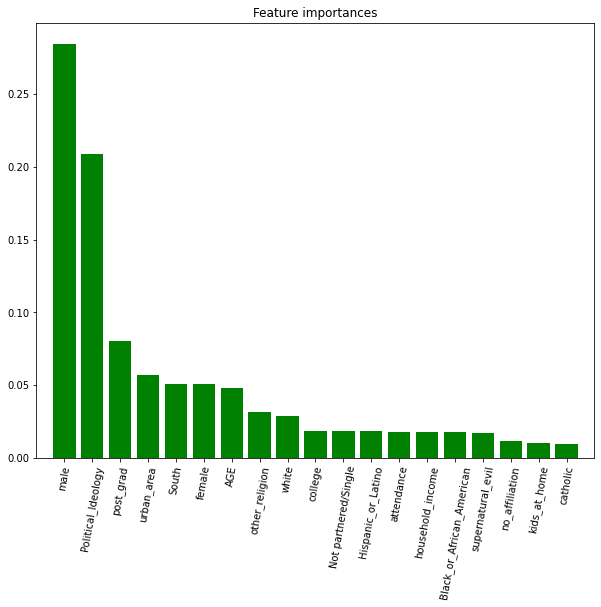

In [412]:
print_tree(max,importances,indices)

## High capacity ammo clips

In [413]:
df_for_tree,feature_cols,x,y,X_train, X_test, y_train, y_test, feature_names = tree_vars('ban_on_high_capacity_ammo_clips')

#### Let's check which tree/forest does the best job. 

In [414]:
max,importances,indices = find_best_tree()

bagging 0.7169434814157865
random forests 0.6914771003942979
xgboost 0.7270982826735467
light 0.7283721680238653


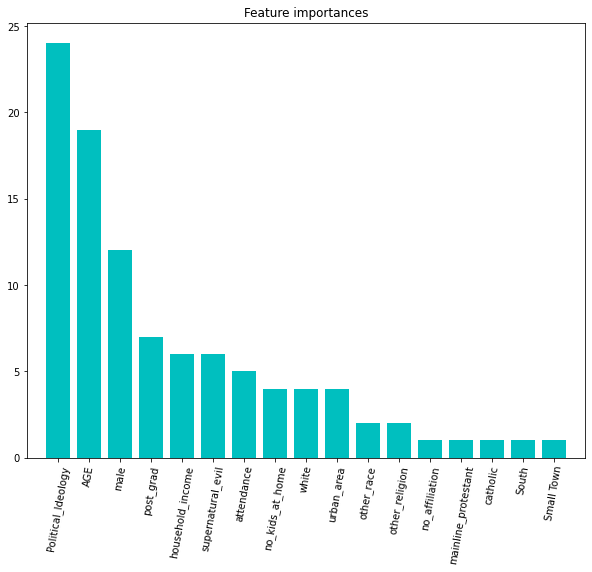

In [415]:
print_tree(max,importances,indices)

## Civilian hand gun possesion ban

In [416]:
df_for_tree,feature_cols,x,y,X_train, X_test, y_train, y_test, feature_names = tree_vars('ban_on_civilian_handguns')

#### Let's check which tree/forest does the best job. 

In [417]:
max,importances,indices = find_best_tree()

bagging 0.706127549786342
random forests 0.7054716408856536
xgboost 0.7156615334999596
light 0.7086672579214705


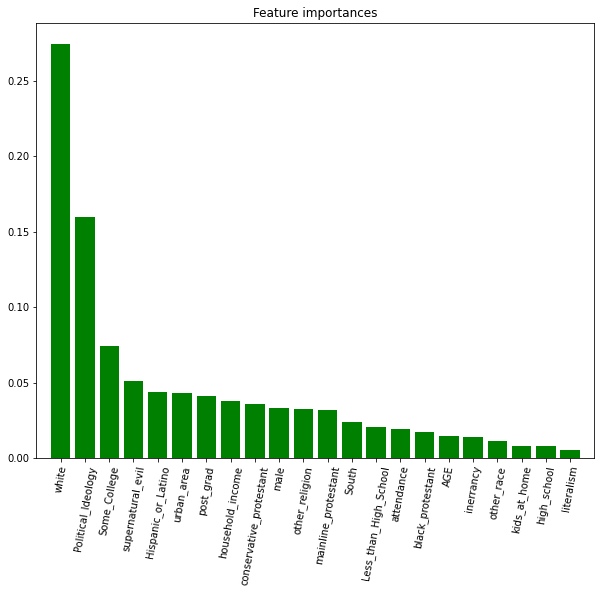

In [418]:
print_tree(max,importances,indices)

## Support for concealed carry

In [419]:
df_for_tree,feature_cols,x,y,X_train, X_test, y_train, y_test, feature_names = tree_vars('support_for_Concealed_Carry_Laws')

#### Let's check which tree/forest does the best job. 

In [420]:
max,importances,indices = find_best_tree()

bagging 0.609380794968959
random forests 0.6545971084824588
xgboost 0.6577844069983068
light 0.6584213496734661


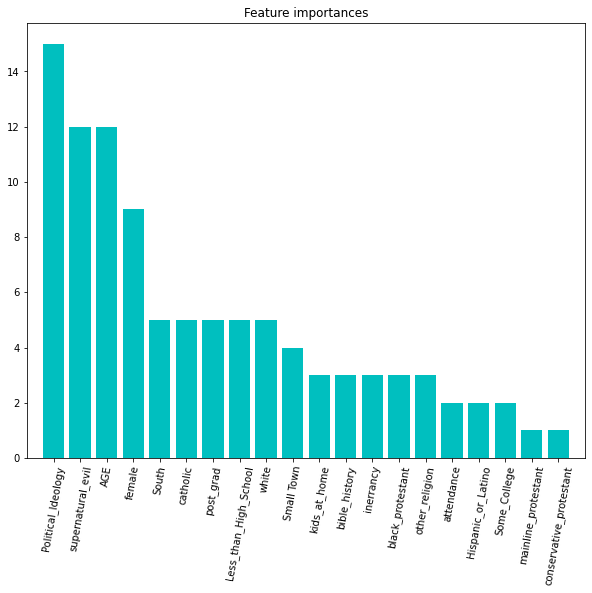

In [421]:
print_tree(max,importances,indices)

## More armed security at schools

In [422]:
df_for_tree,feature_cols,x,y,X_train, X_test, y_train, y_test, feature_names = tree_vars('more_Armed_Security_at_Schools')

#### Let's check which tree/forest does the best job. 

In [423]:
max,importances,indices = find_best_tree()

bagging 0.6736555672014835
random forests 0.6768375290668284
xgboost 0.6831976134806095
light 0.6844997178102072


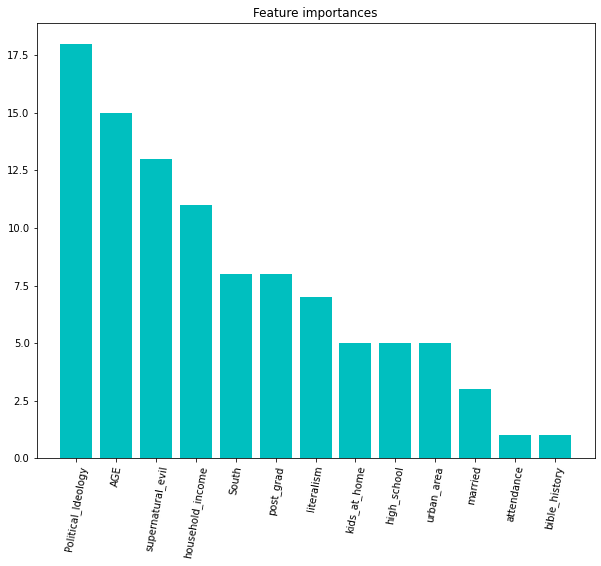

In [424]:
print_tree(max,importances,indices)

## More teachers/faculty with guns

In [425]:
df_for_tree,feature_cols,x,y,X_train, X_test, y_train, y_test, feature_names = tree_vars('more_Teachers_Faculty_having_Guns')

#### Let's check which tree/forest does the best job. 

In [426]:
max,importances,indices = find_best_tree()

bagging 0.707340965895348
random forests 0.7048346982104945
xgboost 0.7207530436184794
light 0.7232846891880997


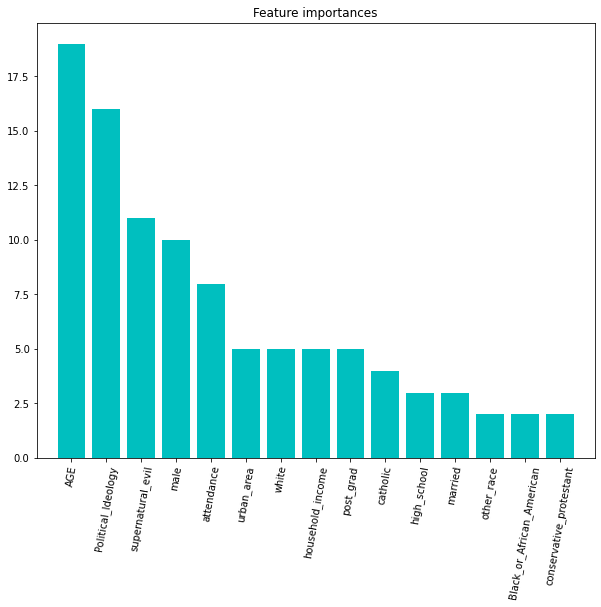

In [427]:
print_tree(max,importances,indices)

### More gun safety programs

In [428]:
df_for_tree,feature_cols,x,y,X_train, X_test, y_train, y_test, feature_names = tree_vars('more_Gun_Safety_Programs')

#### Let's check which tree/forest does the best job. 

In [429]:
max,importances,indices = find_best_tree()

bagging 0.9236716923325001
random forests 0.9274815488828227
xgboost 0.9274852858179475
light 0.9274852858179475


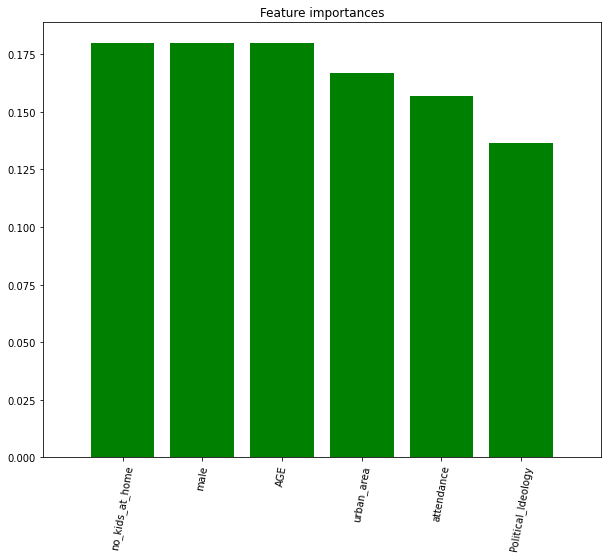

In [430]:
print_tree(max,importances,indices)

## Expanded mental health Screening

In [431]:
df_for_tree,feature_cols,x,y,X_train, X_test, y_train, y_test,  feature_names = tree_vars('expanded_Mental_Health_Screening')

#### Let's check which tree/forest does the best job. 

In [432]:
max,importances,indices = find_best_tree()

bagging 0.9039587196645972
random forests 0.9090344757860682
xgboost 0.9090381359348545
light 0.9090381359348545


## Commentation

Having tried 4 different algorithms to find the best tree to represent each variable we make some conclusions.

* In the first tree, with the ban semi auto weapons depndent variable, we concluded that the male and the political ideology played an important role as features. The supernatural evil was not a very important feature. The best accuracy we succeded was about 71%.  

* In the second tree, the most important characteristics were political ideology and age. However in this case supernatural evil was in the top features. We managed to hit about 73% accuracy here.  

* In the third tree, the white characteristic played a big role followed by political ideology and college. In the fourth place of important characteristcs was supernatural evil. We succeded an approximate 71.5% accuracy.  

* In the fourth tree, supernatural evil climbed into the second position indicating big feature improtance. Accuracy was about 66%.  

* In the fifth tree, the the top 3 characteristics were political ideology, age and supernatural evil. Our model predicted with ~69% accuracy.  

* In the sixth tree, again supernatural evil, which is our focal variable was in the top 3 predictors, helping to create a 72.3% accuracy.  

* In the seventh and eigth trees the accuracy jumped to 92% accuracy with no kids at home and male to be the top predictors.  

* Last but not least, in the last tree we had n accuracy of 90% having political ideology and female in the top places.  

As we can see, supernatural evil,was not our top predictor for trees, but in some of them it was among the top places.


### Thanks to: 
* <code>Stack Overflow</code>, which was my closest friend the past week.
* <code>Pandas documentation </code> which helped me through some diffifcult moments.  